## W266 Project - Essay Scoring

### Data Description

The data is obtained from the Automated Student Assessment Prize (ASAP) AES dataset (https://www.kaggle.com/c/asap-aes/data), which contains essays written by students ranging from Grade 7 to Grade 10. The dataset consists of 8 essay sets, each with a different topic or prompt, with a total of 12,978 essays with scores.

Each of the sets of essays was generated from a single prompt. Selected essays range from an average length of 150 to 550 words per response. Some of the essays are dependent upon source information and others are not. All responses were written by students ranging in grade levels from Grade 7 to Grade 10. All essays were hand graded and were double-scored. Each of the eight data sets has its own unique characteristics. The variability is intended to test the limits of your scoring engine's capabilities.

The training data is provided in three formats: a tab-separated value (TSV) file, a Microsoft Excel 2010 spreadsheet, and a Microsoft Excel 2003 spreadsheet.  The current release of the training data contains essay sets 1-6.  Sets 7-8 will be released on February 10, 2012.  Each of these files contains 28 columns:

    essay_id: A unique identifier for each individual student essay
    essay_set: 1-8, an id for each set of essays
    essay: The ascii text of a student's response
    rater1_domain1: Rater 1's domain 1 score; all essays have this
    rater2_domain1: Rater 2's domain 1 score; all essays have this
    rater3_domain1: Rater 3's domain 1 score; only some essays in set 8 have this.
    domain1_score: Resolved score between the raters; all essays have this
    rater1_domain2: Rater 1's domain 2 score; only essays in set 2 have this
    rater2_domain2: Rater 2's domain 2 score; only essays in set 2 have this
    domain2_score: Resolved score between the raters; only essays in set 2 have this
    rater1_trait1 score - rater3_trait6 score: trait scores for sets 7-8


### Setting up ML libraries

Importing the relevant NLP and tensorflow libraries for our use.

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import json, os, re, shutil, sys, time
from importlib import reload
import collections, itertools
import unittest
from IPython.display import display, HTML

import datetime

# NLTK for NLP utils and corpora
import nltk
nltk.download('punkt')
import string

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# Pandas and SKLearn
import pandas as pd
from sklearn.model_selection import train_test_split

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Helper libraries
from w266_common import utils, patched_numpy_io
#from w266_common import utils, vocabulary, tf_embed_viz

# Your code
#import rnnlm; reload(rnnlm)
#import rnnlm_test; reload(rnnlm_test)

[nltk_data] Downloading package punkt to /home/smus78/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/smus78/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Loading in the data

Data from AES dataset is stored in the `/data/` folder.  We will begin by loading the training dataset `training_set_rel3.tsv` and partitioning it into train, test split.

In [2]:
training_set_rel3_df = pd.read_csv("data/training_set_rel3.csv")
#training_set_rel3_df.head()
print("No. of rows in full data set:", len(training_set_rel3_df))

No. of rows in full data set: 12978


In [3]:
training_set_rel3_df.head(3)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Dropping data with no scores in "domain1_score"
training_set_rel3_df.dropna(axis=0, subset=['domain1_score'], inplace=True)
print("No. of rows in full data set:", len(training_set_rel3_df))

No. of rows in full data set: 12977


In [5]:
# Setting up the prompts
prompt_dict = {1 : 'More and more people use computers, but not everyone agrees that this benefits society. Those who support advances in technology believe that computers have a positive effect on people. They teach hand-eye coordination, give people the ability to learn about faraway places and people, and even allow people to talk online with other people. Others have different ideas. Some experts are concerned that people are spending too much time on their computers and less time exercising, enjoying nature, and interacting with family and friends. Write a letter to your local newspaper in which you state your opinion on the effects computers have on people. Persuade the readers to agree with you.',
               2 : 'Censorship in the Libraries. "All of us can think of a book that we hope none of our children or any other children have taken off the shelf. But if I have the right to remove that book from the shelf -- that work I abhor -- then you also have exactly the same right and so does everyone else. And then we have no books left on the shelf for any of us." --Katherine Paterson, Author. Write a persuasive essay to a newspaper reflecting your views on censorship in libraries. Do you believe that certain materials, such as books, music, movies, magazines, etc., should be removed from the shelves if they are found offensive? Support your position with convincing arguments from your own experience, observations, and/or reading.',
               3 : 'ROUGH ROAD AHEAD: Do Not Exceed Posted Speed Limit -- by Joe Kurmaskie. FORGET THAT OLD SAYING ABOUT NEVER taking candy from strangers. No, a better piece of advice for the solo cyclist would be, “Never accept travel advice from a collection of old-timers who haven’t left the confines of their porches since Carter was in office.” It’s not that a group of old guys doesn’t know the terrain. With age comes wisdom and all that, but the world is a fluid place. Things change. At a reservoir campground outside of Lodi, California, I enjoyed the serenity of an early-summer evening and some lively conversation with these old codgers. What I shouldn’t have done was let them have a peek at my map. Like a foolish youth, the next morning I followed their advice and launched out at first light along a “shortcut” that was to slice away hours from my ride to Yosemite National Park. They’d sounded so sure of themselves when pointing out landmarks and spouting off towns I would come to along this breezy jaunt. Things began well enough. I rode into the morning with strong legs and a smile on my face. About forty miles into the pedal, I arrived at the first “town.” This place might have been a thriving little spot at one time—say, before the last world war—but on that morning it fit the traditional definition of a ghost town. I chuckled, checked my water supply, and moved on. The sun was beginning to beat down, but I barely noticed it. The cool pines and rushing rivers of Yosemite had my name written all over them. Twenty miles up the road, I came to a fork of sorts. One ramshackle shed, several rusty pumps, and a corral that couldn’t hold in the lamest mule greeted me. This sight was troubling. I had been hitting my water bottles pretty regularly, and I was traveling through the high deserts of California in June. I got down on my hands and knees, working the handle of the rusted water pump with all my strength. A tarlike substance oozed out, followed by brackish water feeling somewhere in the neighborhood of two hundred degrees. I pumped that handle for several minutes, but the water wouldn’t cool down. It didn’t matter. When I tried a drop or two, it had the flavor of battery acid. The old guys had sworn the next town was only eighteen miles down the road. I could make that! I would conserve my water and go inward for an hour or so—a test of my inner spirit. Not two miles into this next section of the ride, I noticed the terrain changing. Flat road was replaced by short, rolling hills. After I had crested the first few of these, a large highway sign jumped out at me. It read: ROUGH ROAD AHEAD: DO NOT EXCEED POSTED SPEED LIMIT. The speed limit was 55 mph. I was doing a water-depleting 12 mph. Sometimes life can feel so cruel. I toiled on. At some point, tumbleweeds crossed my path and a ridiculously large snake—it really did look like a diamondback—blocked the majority of the pavement in front of me. I eased past, trying to keep my balance in my dehydrated state. The water bottles contained only a few tantalizing sips. Wide rings of dried sweat circled my shirt, and the growing realization that I could drop from heatstroke on a gorgeous day in June simply because I listened to some gentlemen who hadn’t been off their porch in decades, caused me to laugh. It was a sad, hopeless laugh, mind you, but at least I still had the energy to feel sorry for myself. There was no one in sight, not a building, car, or structure of any kind. I began breaking the ride down into distances I could see on the horizon, telling myself that if I could make it that far, I’d be fine. Over one long, crippling hill, a building came into view. I wiped the sweat from my eyes to make sure it wasn’t a mirage, and tried not to get too excited. With what I believed was my last burst of energy, I maneuvered down the hill. In an ironic twist that should please all sadists reading this, the building—abandoned years earlier, by the looks of it—had been a Welch’s Grape Juice factory and bottling plant. A sandblasted picture of a young boy pouring a refreshing glass of juice into his mouth could still be seen. I hung my head. That smoky blues tune “Summertime” rattled around in the dry honeycombs of my deteriorating brain. I got back on the bike, but not before I gathered up a few pebbles and stuck them in my mouth. I’d read once that sucking on stones helps take your mind off thirst by allowing what spit you have left to circulate. With any luck I’d hit a bump and lodge one in my throat. It didn’t really matter. I was going to die and the birds would pick me clean, leaving only some expensive outdoor gear and a diary with the last entry in praise of old men, their wisdom, and their keen sense of direction. I made a mental note to change that paragraph if it looked like I was going to lose consciousness for the last time. Somehow, I climbed away from the abandoned factory of juices and dreams, slowly gaining elevation while losing hope. Then, as easily as rounding a bend, my troubles, thirst, and fear were all behind me. GARY AND WILBER’S FISH CAMP—IF YOU WANT BAIT FOR THE BIG ONES, WE’RE YOUR BEST BET! “And the only bet,” I remember thinking. As I stumbled into a rather modern bathroom and drank deeply from the sink, I had an overwhelming urge to seek out Gary and Wilber, kiss them, and buy some bait—any bait, even though I didn’t own a rod or reel. An old guy sitting in a chair under some shade nodded in my direction. Cool water dripped from my head as I slumped against the wall beside him. “Where you headed in such a hurry?” “Yosemite,” I whispered. “Know the best way to get there?” I watched him from the corner of my eye for a long moment. He was even older than the group I’d listened to in Lodi. “Yes, sir! I own a very good map.” And I promised myself right then that I’d always stick to it in the future. “Rough Road Ahead” by Joe Kurmaskie, from Metal Cowboy, copyright © 1999 Joe Kurmaskie. Write a response that explains how the features of the setting affect the cyclist. In your response, include examples from the essay that support your conclusion.',
               4 : 'Winter Hibiscus by Minfong Ho Saeng, a teenage girl, and her family have moved to the United States from Vietnam. As Saeng walks home after failing her driver’s test, she sees a familiar plant. Later, she goes to a florist shop to see if the plant can be purchased. It was like walking into another world. A hot, moist world exploding with greenery. Huge flat leaves, delicate wisps of tendrils, ferns and fronds and vines of all shades and shapes grew in seemingly random profusion. “Over there, in the corner, the hibiscus. Is that what you mean?” The florist pointed at a leafy potted plant by the corner. There, in a shaft of the wan afternoon sunlight, was a single blood-red blossom, its five petals splayed back to reveal a long stamen tipped with yellow pollen. Saeng felt a shock of recognition so intense, it was almost visceral. “Saebba,” Saeng whispered. A saebba hedge, tall and lush, had surrounded their garden, its lush green leaves dotted with vermilion flowers. And sometimes after a monsoon rain, a blossom or two would have blown into the well, so that when she drew the well water, she would find a red blossom floating in the bucket. Slowly, Saeng walked down the narrow aisle toward the hibiscus. Orchids, lanna bushes, oleanders, elephant ear begonias, and bougainvillea vines surrounded her. Plants that she had not even realized she had known but had forgotten drew her back into her childhood world. When she got to the hibiscus, she reached out and touched a petal gently. It felt smooth and cool, with a hint of velvet toward the center—just as she had known it would feel. And beside it was yet another old friend, a small shrub with waxy leaves and dainty flowers with purplish petals and white centers. “Madagascar periwinkle,” its tag announced. How strange to see it in a pot, Saeng thought. Back home it just grew wild, jutting out from the cracks in brick walls or between tiled roofs. And that rich, sweet scent—that was familiar, too. Saeng scanned the greenery around her and found a tall, gangly plant with exquisite little white blossoms on it.  “Dok Malik,” she said, savoring the feel of the word on her tongue, even as she silently noted the English name on its tag, “jasmine.” One of the blossoms had fallen off, and carefully Saeng picked it up and smelled it. She closed her eyes and breathed in, deeply. The familiar fragrance filled her lungs, and Saeng could almost feel the light strands of her grandmother’s long gray hair, freshly washed, as she combed it out with the fine-toothed buffalo-horn comb. And when the sun had dried it, Saeng would help the gnarled old fingers knot the hair into a bun, then slip a dok Malik bud into it. Saeng looked at the white bud in her hand now, small and fragile. Gently, she closed her palm around it and held it tight. That, at least, she could hold on to. But where was the fine-toothed comb? The hibiscus hedge? The well? Her gentle grandmother? A wave of loss so deep and strong that it stung Saeng’s eyes now swept over her. A blink, a channel switch, a boat ride into the night, and it was all gone. Irretrievably, irrevocably gone. And in the warm moist shelter of the greenhouse, Saeng broke down and wept. It was already dusk when Saeng reached home. The wind was blowing harder, tearing off the last remnants of green in the chicory weeds that were growing out of the cracks in the sidewalk. As if oblivious to the cold, her mother was still out in the vegetable garden, digging up the last of the onions with a rusty trowel. She did not see Saeng until the girl had quietly knelt down next to her. Her smile of welcome warmed Saeng. “Ghup ma laio le? You’re back?” she said cheerfully. “Goodness, it’s past five. What took you so long? How did it go? Did you—?” Then she noticed the potted plant that Saeng was holding, its leaves quivering in the wind. Mrs. Panouvong uttered a small cry of surprise and delight. “Dok faeng-noi!” she said. “Where did you get it?” “I bought it,” Saeng answered, dreading her mother’s next question. “How much?” For answer Saeng handed her mother some coins. “That’s all?” Mrs. Panouvong said, appalled, “Oh, but I forgot! You and the Lambert boy ate Bee-Maags . . . .” “No, we didn’t, Mother,” Saeng said. “Then what else—?” “Nothing else. I paid over nineteen dollars for it.” “You what?” Her mother stared at her incredulously. “But how could you? All the seeds for this vegetable garden didn’t cost that much! You know how much we—” She paused, as she noticed the tearstains on her daughter’s cheeks and her puffy eyes. “What happened?” she asked, more gently. “I—I failed the test,” Saeng said. For a long moment Mrs. Panouvong said nothing. Saeng did not dare look her mother in the eye. Instead, she stared at the hibiscus plant and nervously tore off a leaf, shredding it to bits. Her mother reached out and brushed the fragments of green off Saeng’s hands. “It’s a beautiful plant, this dok faeng-noi,” she finally said. “I’m glad you got it.” “It’s—it’s not a real one,” Saeng mumbled. “I mean, not like the kind we had at—at—” She found that she was still too shaky to say the words at home, lest she burst into tears again. “Not like the kind we had before,” she said. “I know,” her mother said quietly. “I’ve seen this kind blooming along the lake. Its flowers aren’t as pretty, but it’s strong enough to make it through the cold months here, this winter hibiscus. That’s what matters.” She tipped the pot and deftly eased the ball of soil out, balancing the rest of the plant in her other hand. “Look how root-bound it is, poor thing,” she said. “Let’s plant it, right now.” She went over to the corner of the vegetable patch and started to dig a hole in the ground. The soil was cold and hard, and she had trouble thrusting the shovel into it. Wisps of her gray hair trailed out in the breeze, and her slight frown deepened the wrinkles around her eyes. There was a frail, wiry beauty to her that touched Saeng deeply. “Here, let me help, Mother,” she offered, getting up and taking the shovel away from her. Mrs. Panouvong made no resistance. “I’ll bring in the hot peppers and bitter melons, then, and start dinner. How would you like an omelet with slices of the bitter melon?” “I’d love it,” Saeng said. Left alone in the garden, Saeng dug out a hole and carefully lowered the “winter hibiscus” into it. She could hear the sounds of cooking from the kitchen now, the beating of eggs against a bowl, the sizzle of hot oil in the pan. The pungent smell of bitter melon wafted out, and Saeng’s mouth watered. It was a cultivated taste, she had discovered—none of her classmates or friends, not even Mrs. Lambert, liked it—this sharp, bitter melon that left a golden aftertaste on the tongue. But she had grown up eating it and, she admitted to herself, much preferred it to a Big Mac. The “winter hibiscus” was in the ground now, and Saeng tamped down the soil around it. Overhead, a flock of Canada geese flew by, their faint honks clear and—yes—familiar to Saeng now. Almost reluctantly, she realized that many of the things that she had thought of as strange before had become, through the quiet repetition of season upon season, almost familiar to her now. Like the geese. She lifted her head and watched as their distinctive V was etched against the evening sky, slowly fading into the distance. When they come back, Saeng vowed silently to herself, in the spring, when the snows melt and the geese return and this hibiscus is budding, then I will take that test again. “Winter Hibiscus” by Minfong Ho, copyright © 1993 by Minfong Ho, from Join In, Multiethnic Short Stories, by Donald R. Gallo, ed. Read the last paragraph of the story. "When they come back, Saeng vowed silently to herself, in the spring, when the snows melt and the geese return and this hibiscus is budding, then I will take that test again." Write a response that explains why the author concludes the story with this paragraph. In your response, include details and examples from the story that support your ideas.',
               5 : 'Narciso Rodriguez from Home: The Blueprints of Our Lives My parents, originally from Cuba, arrived in the United States in 1956. After living for a year in a furnished one-room apartment, twenty-one-year-old Rawedia Maria and twenty-seven-year-old Narciso Rodriguez, Sr., could afford to move into a modest, three-room apartment I would soon call home. In 1961, I was born into this simple house, situated in a two-family, blond-brick building in the Ironbound section of Newark, New Jersey. Within its walls, my young parents created our traditional Cuban home, the very heart of which was the kitchen. My parents both shared cooking duties and unwittingly passed on to me their rich culinary skills and a love of cooking that is still with me today (and for which I am eternally grateful). Passionate Cuban music (which I adore to this day) filled the air, mixing with the aromas of the kitchen. Here, the innocence of childhood, the congregation of family and friends, and endless celebrations that encompassed both, formed the backdrop to life in our warm home. Growing up in this environment instilled in me a great sense that “family” had nothing to do with being a blood relative. Quite the contrary, our neighborhood was made up of mostly Spanish, Cuban, and Italian immigrants at a time when overt racism was the norm and segregation prevailed in the United States. In our neighborhood, despite customs elsewhere, all of these cultures came together in great solidarity and friendship. It was a close-knit community of honest, hardworking immigrants who extended a hand to people who, while not necessarily their own kind, were clearly in need. Our landlord and his daughter, Alegria (my babysitter and first friend), lived above us, and Alegria graced our kitchen table for meals more often than not. Also at the table were Sergio and Edelmira, my surrogate grandparents who lived in the basement apartment. (I would not know my “real” grandparents, Narciso the Elder and Consuelo, until 1970 when they were allowed to leave Cuba.) My aunts Bertha and Juanita and my cousins Arnold, Maria, and Rosemary also all lived nearby and regularly joined us at our table. Countless extended family members came and went — and there was often someone staying with us temporarily until they were able to get back on their feet. My parents always kept their arms and their door open to the many people we considered family, knowing that they would do the same for us. My mother and father had come to this country with such courage, without any knowledge of the language or the culture. They came selflessly, as many immigrants do, to give their children a better life, even though it meant leaving behind their families, friends, and careers in the country they loved. They struggled both personally and financially, braving the harsh northern winters while yearning for their native tropics and facing cultural hardships. The barriers to work were strong and high, and my parents both had to accept that they might not be able to find the kind of jobs they deserved. In Cuba, Narciso, Sr., had worked in a laboratory and Rawedia Maria had studied chemical engineering. In the United States, they had to start their lives over entirely, taking whatever work they could find. The faith that this struggle would lead them and their children to better times drove them to endure these hard times. I will always be grateful to my parents for their love and sacrifice. I’ve often told them that what they did was a much more courageous thing than I could have ever done. I’ve often told them of my admiration for their strength and perseverance, and I’ve thanked them repeatedly. But, in reality, there is no way to express my gratitude for the spirit of generosity impressed upon me at such an early age and the demonstration of how important family and friends are. These are two lessons that my parents did not just tell me. They showed me with their lives, and these teachings have been the basis of my life. It was in this simple house that my parents welcomed other refugees to celebrate their arrival to this country and where I celebrated my first birthdays. It was in the warmth of the kitchen in this humble house where a Cuban feast (albeit a frugal Cuban feast) always filled the air with not just scent and music but life and love. It was here where I learned the real definition of “family.” And for this, I will never forget that house or its gracious neighborhood or the many things I learned there about how to love. I will never forget how my parents turned this simple house into a home. — Narciso Rodriguez, Fashion designer. Hometown: Newark, New Jersey. “Narciso Rodriguez” by Narciso Rodriguez, from Home: The Blueprints of Our Lives. Copyright © 2006 by John Edwards. Describe the mood created by the author in the memoir. Support your answer with relevant and specific information from the memoir.',
               6 : 'The Mooring Mast by Marcia Amidon Lüsted. When the Empire State Building was conceived, it was planned as the world’s tallest building, taller even than the new Chrysler Building that was being constructed at Forty-second Street and Lexington Avenue in New York. At seventy-seven stories, it was the tallest building before the Empire State began construction, and Al Smith was determined to outstrip it in height. The architect building the Chrysler Building, however, had a trick up his sleeve. He secretly constructed a 185-foot spire inside the building, and then shocked the public and the media by hoisting it up to the top of the Chrysler Building, bringing it to a height of 1,046 feet, 46 feet taller than the originally announced height of the Empire State Building. Al Smith realized that he was close to losing the title of world’s tallest building, and on December 11, 1929, he announced that the Empire State would now reach the height of 1,250 feet. He would add a top or a hat to the building that would be even more distinctive than any other building in the city. John Tauranac describes the plan: [The top of the Empire State Building] would be more than ornamental, more than a spire or dome or a pyramid put there to add a desired few feet to the height of the building or to mask something as mundane as a water tank. Their top, they said, would serve a higher calling. The Empire State Building would be equipped for an age of transportation that was then only the dream of aviation pioneers. This dream of the aviation pioneers was travel by dirigible, or zeppelin, and the Empire State Building was going to have a mooring mast at its top for docking these new airships, which would accommodate passengers on already existing transatlantic routes and new routes that were yet to come. The Age of Dirigibles. By the 1920s, dirigibles were being hailed as the transportation of the future. Also known today as blimps, dirigibles were actually enormous steel-framed balloons, with envelopes of cotton fabric filled with hydrogen and helium to make them lighter than air. Unlike a balloon, a dirigible could be maneuvered by the use of propellers and rudders, and passengers could ride in the gondola, or enclosed compartment, under the balloon.Dirigibles had a top speed of eighty miles per hour, and they could cruise at seventy miles per hour for thousands of miles without needing refueling. Some were as long as one thousand feet, the same length as four blocks in New York City. The one obstacle to their expanded use in New York City was the lack of a suitable landing area. Al Smith saw an opportunity for his Empire State Building: A mooring mast added to the top of the building would allow dirigibles to anchor there for several hours for refueling or service, and to let passengers off and on. Dirigibles were docked by means of an electric winch, which hauled in a line from the front of the ship and then tied it to a mast. The body of the dirigible could swing in the breeze, and yet passengers could safely get on and off the dirigible by walking down a gangplank to an open observation platform. The architects and engineers of the Empire State Building consulted with experts, taking tours of the equipment and mooring operations at the U.S. Naval Air Station in Lakehurst, New Jersey. The navy was the leader in the research and development of dirigibles in the United States. The navy even offered its dirigible, the Los Angeles, to be used in testing the mast. The architects also met with the president of a recently formed airship transport company that planned to offer dirigible service across the Pacific Ocean. When asked about the mooring mast, Al Smith commented: [It’s] on the level, all right. No kidding. We’re working on the thing now. One set of engineers here in New York is trying to dope out a practical, workable arrangement and the Government people in Washington are figuring on some safe way of mooring airships to this mast. Designing the Mast. The architects could not simply drop a mooring mast on top of the Empire State Building’s flat roof. A thousand-foot dirigible moored at the top of the building, held by a single cable tether, would add stress to the building’s frame. The stress of the dirigible’s load and the wind pressure would have to be transmitted all the way to the building’s foundation, which was nearly eleven hundred feet below. The steel frame of the Empire State Building would have to be modified and strengthened to accommodate this new situation. Over sixty thousand dollars’ worth of modifications had to be made to the building’s framework. Rather than building a utilitarian mast without any ornamentation, the architects designed a shiny glass and chrome-nickel stainless steel tower that would be illuminated from inside, with a stepped-back design that imitated the overall shape of the building itself. The rocket-shaped mast would have four wings at its corners, of shiny aluminum, and would rise to a conical roof that would house the mooring arm. The winches and control machinery for the dirigible mooring would be housed in the base of the shaft itself, which also housed elevators and stairs to bring passengers down to the eighty-sixth floor, where baggage and ticket areas would be located. The building would now be 102 floors, with a glassed-in observation area on the 101st floor and an open observation platform on the 102nd floor. This observation area was to double as the boarding area for dirigible passengers. Once the architects had designed the mooring mast and made changes to the existing plans for the building’s skeleton, construction proceeded as planned. When the building had been framed to the 85th floor, the roof had to be completed before the framing for the mooring mast could take place. The mast also had a skeleton of steel and was clad in stainless steel with glass windows. Two months after the workers celebrated framing the entire building, they were back to raise an American flag again—this time at the top of the frame for the mooring mast. The Fate of the Mast. The mooring mast of the Empire State Building was destined to never fulfill its purpose, for reasons that should have been apparent before it was ever constructed. The greatest reason was one of safety: Most dirigibles from outside of the United States used hydrogen rather than helium, and hydrogen is highly flammable. When the German dirigible Hindenburg was destroyed by fire in Lakehurst, New Jersey, on May 6, 1937, the owners of the Empire State Building realized how much worse that accident could have been if it had taken place above a densely populated area such as downtown New York. The greatest obstacle to the successful use of the mooring mast was nature itself. The winds on top of the building were constantly shifting due to violent air currents. Even if the dirigible were tethered to the mooring mast, the back of the ship would swivel around and around the mooring mast. Dirigibles moored in open landing fields could be weighted down in the back with lead weights, but using these at the Empire State Building, where they would be dangling high above pedestrians on the street, was neither practical nor safe. The other practical reason why dirigibles could not moor at the Empire State Building was an existing law against airships flying too low over urban areas. This law would make it illegal for a ship to ever tie up to the building or even approach the area, although two dirigibles did attempt to reach the building before the entire idea was dropped. In December 1930, the U.S. Navy dirigible Los Angeles approached the mooring mast but could not get close enough to tie up because of forceful winds. Fearing that the wind would blow the dirigible onto the sharp spires of other buildings in the area, which would puncture the dirigible’s shell, the captain could not even take his hands off the control levers. Two weeks later, another dirigible, the Goodyear blimp Columbia, attempted a publicity stunt where it would tie up and deliver a bundle of newspapers to the Empire State Building. Because the complete dirigible mooring equipment had never been installed, a worker atop the mooring mast would have to catch the bundle of papers on a rope dangling from the blimp. The papers were delivered in this fashion, but after this stunt the idea of using the mooring mast was shelved. In February 1931, Irving Clavan of the building’s architectural office said, “The as yet unsolved problems of mooring air ships to a fixed mast at such a height made it desirable to postpone to a later date the final installation of the landing gear.” By the late 1930s, the idea of using the mooring mast for dirigibles and their passengers had quietly disappeared. Dirigibles, instead of becoming the transportation of the future, had given way to airplanes. The rooms in the Empire State Building that had been set aside for the ticketing and baggage of dirigible passengers were made over into the world’s highest soda fountain and tea garden for use by the sightseers who flocked to the observation decks. The highest open observation deck, intended for disembarking passengers, has never been open to the public. “The Mooring Mast” by Marcia Amidon Lüsted, from The Empire State Building. Copyright © 2004 by Gale, a part of Cengage Learning, Inc. Based on the excerpt, describe the obstacles the builders of the Empire State Building faced in attempting to allow dirigibles to dock there. Support your answer with relevant and specific information from the excerpt.',
               7 : 'Write about patience. Being patient means that you are understanding and tolerant. A patient person experience difficulties without complaining. Do only one of the following: write a story about a time when you were patient OR write a story about a time when someone you know was patient OR write a story in your own way about patience.',
               8 : 'We all understand the benefits of laughter. For example, someone once said, “Laughter is the shortest distance between two people.” Many other people believe that laughter is an important part of any relationship. Tell a true story in which laughter was one element or part.'
              }

In [6]:
# Adding prompts column into the dataframe
training_set_rel3_df.insert(loc=2, column="prompt", 
                            value=[prompt_dict[i] for i in training_set_rel3_df["essay_set"]])

# Adding the normalized scores column into the dataframe
# training_set_rel3_df.insert(loc=4, column="scores", 
#                             value=[(row["domain1_score"]-2)/10 if row["essay_set"]==1 else 
#                                    (row["domain1_score"]-1 + row["domain2_score"]-1)/(5+3) if row["essay_set"]==2 else
#                                    (row["domain1_score"])/3 if row["essay_set"]==3 else
#                                    (row["domain1_score"])/3 if row["essay_set"]==4 else
#                                    (row["domain1_score"])/4 if row["essay_set"]==5 else
#                                    (row["domain1_score"])/4 if row["essay_set"]==6 else
#                                    (row["domain1_score"])/30 if row["essay_set"]==7 else
#                                    (row["domain1_score"])/60
#                                    for index, row in training_set_rel3_df.iterrows() 
#                                   ]
#                            )

# Adding the scores column into the dataframe, which are [0, 10]
training_set_rel3_df.insert(loc=4, column="scores", 
                            value=[np.int(round((row["domain1_score"]-2)/10 * 10)) if row["essay_set"]==1 else 
                                   np.int(round((row["domain1_score"]-1 + row["domain2_score"]-1)/(5+3) * 10)) if row["essay_set"]==2 else
                                   np.int(round((row["domain1_score"])/3 * 10)) if row["essay_set"]==3 else
                                   np.int(round((row["domain1_score"])/3 * 10)) if row["essay_set"]==4 else
                                   np.int(round((row["domain1_score"])/4 * 10)) if row["essay_set"]==5 else
                                   np.int(round((row["domain1_score"])/4 * 10)) if row["essay_set"]==6 else
                                   np.int(round((row["domain1_score"])/30 * 10)) if row["essay_set"]==7 else
                                   np.int(round((row["domain1_score"])/60 * 10))
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )


In [7]:
# Tokenization and stripping @*** (@CAPS1, @ORGANIZATION1) using the TweetTokenizer with strip_handles=True
# Also convert to lowercase and strip punctuation (except @***)
tknzr = nltk.tokenize.TweetTokenizer(strip_handles=True)
dropped_punctuation = ''.join(s for s in string.punctuation if s!='@')
dropped_punctuation = string.punctuation + '”“’—©'

# Tokenizing the prompts
tk_prompt_dict = {i:tknzr.tokenize(prompt_dict[i]) for i in prompt_dict.keys()}
# Removing punctuation
for i in tk_prompt_dict.keys():
    tk_prompt_dict[i] = list(map(lambda x:x.translate(str.maketrans('', '', dropped_punctuation)).lower(),tk_prompt_dict[i]))
    tk_prompt_dict[i] = [str(w).replace(' ','') for w in tk_prompt_dict[i]]
    tk_prompt_dict[i] = [s for s in tk_prompt_dict[i] if s]

# Adding a column for tokenized prompt
training_set_rel3_df.insert(loc=5, column="tk_prompt", 
                            value=[tk_prompt_dict[i] for i in training_set_rel3_df["essay_set"]])

# Tokenizing the essays
tk_essay_list = [tknzr.tokenize(row["essay"]) for index, row in training_set_rel3_df.iterrows()]
# Removing punctuation
for i in range(len(tk_essay_list)):
    tk_essay_list[i] = list(map(lambda x:x.translate(str.maketrans('', '', dropped_punctuation)).lower(),tk_essay_list[i]))
    tk_essay_list[i] = [str(w).replace(' ','') for w in tk_essay_list[i]]
    tk_essay_list[i] = [s for s in tk_essay_list[i] if s]

# Adding a column for tokenized essay
training_set_rel3_df.insert(loc=6, column="tk_essay", 
                            value=[tk_essay_list[i] for i in range(len(tk_essay_list))])

In [8]:
training_set_rel3_df.tail(3)

,essay_id,essay_set,prompt,essay,scores,tk_prompt,tk_essay,rater1_domain1,rater2_domain1,rater3_domain1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
12975,21629,8,We all understand the benefits of laughter. Fo...,"When you laugh, is @CAPS5 out of habit, or is ...",7,"[we, all, understand, the, benefits, of, laugh...","[when, you, laugh, is, out, of, habit, or, is,...",20.0,26.0,40.0,...,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0
12976,21630,8,We all understand the benefits of laughter. Fo...,Trippin' on fen...,7,"[we, all, understand, the, benefits, of, laugh...","[trippin, on, fences, i, am, years, young, and...",20.0,20.0,NaN,...,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
12977,21633,8,We all understand the benefits of laughter. Fo...,Many people believe that laughter can improve...,7,"[we, all, understand, the, benefits, of, laugh...","[many, people, believe, that, laughter, can, i...",20.0,20.0,NaN,...,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


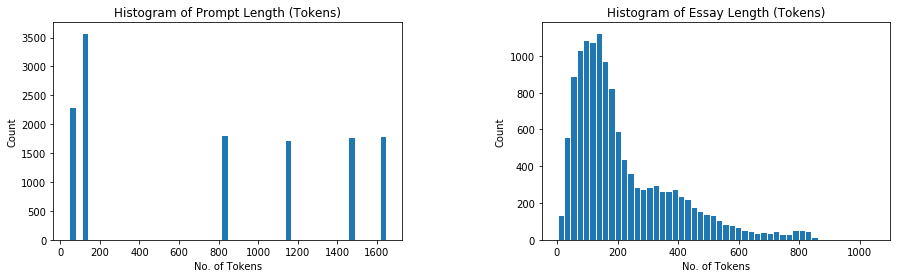

In [9]:
# Plotting histogram for prompt and essay token lengths
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.subplots_adjust(wspace=.4)

prompt_len = [len(training_set_rel3_df["tk_prompt"][index]) for index, row in training_set_rel3_df.iterrows()]
essay_len = [len(training_set_rel3_df["tk_essay"][index]) for index, row in training_set_rel3_df.iterrows()]

ax[0].hist(x=prompt_len, bins=50, edgecolor="w")
ax[0].set_title("Histogram of Prompt Length (Tokens)")
ax[0].set_xlabel("No. of Tokens")
ax[0].set_ylabel("Count")

ax[1].hist(x=essay_len, bins=50, edgecolor="w")
ax[1].set_title("Histogram of Essay Length (Tokens)")
ax[1].set_xlabel("No. of Tokens")
ax[1].set_ylabel("Count")

plt.show()

In [10]:
# Setting parameters for max_len
print("Prompt lengths =", set(prompt_len))
max_len_p = 130
print("Setting max_len_p =", max_len_p)
print()

max_len = 650
print("Setting max_len = {}, \n {:.1f}% of essays are shorter than this length."
      .format(max_len, 100*sum(i <= max_len for i in essay_len) / len(training_set_rel3_df)))

Prompt lengths = {1153, 836, 45, 111, 1649, 1460, 58, 127}
Setting max_len_p = 130

Setting max_len = 650, 
 96.8% of essays are shorter than this length.


In [11]:
# Padding and trunking for array export
# Padding and trunking will be done at the beginning for prompts. 
training_set_rel3_df.insert(loc=7, column="tk_pad_prompt", 
                            value=[row["tk_prompt"][-max_len_p:] if len(row["tk_prompt"])>max_len_p else
                                   ["<s>" for n in range(max_len_p - len(row["tk_prompt"]))] + row["tk_prompt"] 
                                   if len(row["tk_prompt"])<max_len_p else
                                   row["tk_prompt"]
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

# Padding and trunking will be done at the ending for essays. 
training_set_rel3_df.insert(loc=8, column="tk_pad_essay", 
                            value=[row["tk_essay"][:max_len] if len(row["tk_essay"])>max_len else
                                   row["tk_essay"] + ["<s>" for n in range(max_len - len(row["tk_essay"]))] 
                                   if len(row["tk_essay"])<max_len else
                                   row["tk_essay"]
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

# Adding columns for the length of the truncated prompt and the essay to identify no. of words before padding
training_set_rel3_df.insert(loc=9, column="nw_prompt", 
                            value=[len(row["tk_prompt"]) if len(row["tk_prompt"])<max_len_p else
                                   max_len_p
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

training_set_rel3_df.insert(loc=10, column="nw_essay", 
                            value=[len(row["tk_essay"]) if len(row["tk_essay"])<max_len else
                                   max_len
                                   for index, row in training_set_rel3_df.iterrows() 
                                  ]
                           )

# Checks for the length of the tokens
assert set([len(training_set_rel3_df["tk_pad_prompt"][index]) 
            for index, row in training_set_rel3_df.iterrows()])==set([max_len_p]), "Checks for Prompt padding fail"
assert set([len(training_set_rel3_df["tk_pad_essay"][index])
            for index, row in training_set_rel3_df.iterrows()])==set([max_len]), "Checks for Essay padding fail"

In [12]:
# Creating train, dev and test sets
train_set, test_set = train_test_split(training_set_rel3_df, test_size=0.1, random_state=0)
train_set, dev_set = train_test_split(train_set, test_size=15/90, random_state=0)

# Testing only on prompt 1
# train_set, test_set = train_test_split(training_set_rel3_df[training_set_rel3_df["essay_set"] == 1],
#                                                                   test_size=0.1, random_state=0)
# train_set, dev_set = train_test_split(train_set, test_size=15/90, random_state=0)

In [13]:
print("No. of examples in Train Set :", len(train_set))
print("No. of examples in Dev Set   :", len(dev_set))
print("No. of examples in Test Set  :", len(test_set))

No. of examples in Train Set : 9732
No. of examples in Dev Set   : 1947
No. of examples in Test Set  : 1298


In [14]:
# Extracting out as arrays, Note: still need to convert to ids based on the embedding
train_set_prompts = np.array(list(train_set["tk_pad_prompt"]))
train_set_essays = np.array(list(train_set["tk_pad_essay"]))
train_set_labels = np.array(list(train_set["scores"]))

dev_set_prompts = np.array(list(dev_set["tk_pad_prompt"]))
dev_set_essays = np.array(list(dev_set["tk_pad_essay"]))
dev_set_labels = np.array(list(dev_set["scores"]))

test_set_prompts = np.array(list(test_set["tk_pad_prompt"]))
test_set_essays = np.array(list(test_set["tk_pad_essay"]))
test_set_labels = np.array(list(test_set["scores"]))

In [15]:
# Extracting out the no. of words prior to padding
train_set_prompt_nw = np.array(list(train_set["nw_prompt"]))
train_set_essay_nw = np.array(list(train_set["nw_essay"]))

dev_set_prompt_nw = np.array(list(dev_set["nw_prompt"]))
dev_set_essay_nw = np.array(list(dev_set["nw_essay"]))

test_set_prompt_nw = np.array(list(test_set["nw_prompt"]))
test_set_essay_nw = np.array(list(test_set["nw_essay"]))

In [16]:
# Checking the array shape
assert train_set_essays.shape == (len(train_set),max_len), "Checks for array shape fail"

#Checking first 10 tokens of index 0 of train_set_essays
train_set_essays[0][:10]

array(['the', 'mood', 'in', 'the', 'memoir', 'that', 'the', 'author',
       'creates', 'is'], dtype='<U35')

### Baseline

A baseline was established with Neural Bag of Words

![Neural Bag-of-Words Model](images/neural_bow.png)

Using the following notation:
- $w^{(i)} \in \mathbb{Z}$ for the $i^{th}$ word of the sequence (as an integer index)
- $x^{(i)} \in \mathbb{R}^d$ for the vector representation (embedding) of $w^{(i)}$
- $x \in \mathbb{R}^d$ for the fixed-length vector given by summing all the $x^{(i)}$ for an example
- $h^{(j)}$ for the hidden state after the $j^{th}$ fully-connected layer
- $y$ for the target label ($\in 1,\ldots,\mathtt{num\_classes}$)

Our model is defined as:
- **Embedding layer:** $x^{(i)} = W_{embed}[w^{(i)}]$
- **Summing vectors:** $x = \sum_{i=1}^n x^{(i)}$
- **Hidden layer(s):** $h^{(j)} = f(h^{(j-1)} W^{(j)} + b^{(j)})$ where $h^{(-1)} = x$ and $j = 0,1,\ldots,J-1$
- **Output layer:** $\hat{y} = \hat{P}(y) = \mathrm{softmax}(h^{(final)} W_{out} + b_{out})$ where $h^{(final)} = h^{(J-1)}$ is the output of the last hidden layer.

Logits for the softmax is defined as:
$$ \mathrm{logits} = h^{(final)}W_{out} + b_{out} $$

Other dimensions:
- `V`: the vocabulary size
- `embed_dim`: the embedding dimension $d$
- `hidden_dims`: a list of dimensions for the output of each hidden layer (i.e. $\mathrm{dim}(h^{(j)})$&nbsp;=&nbsp;`hidden_dims[j]`)
- `num_classes`: the number of target classes (2 for the binary task)

In [ ]:
# Building the Vocabulary

# Set the threshold number of occurences to prune words from the vocab
prune_threshold = 5

# Defining sorting and unique functions
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item

def sort_and_deduplicate(lst):
    return list(uniq(sorted(lst, reverse=False)))

def word_ctr(lst):
    ctr_list = []
    last = object()
    for word in lst:
        if word == last:
            ctr_list[-1] += 1
        else:
            ctr_list.append(1)
        last = word
    return ctr_list

def prune(lst, ctr_lst, num=10):
    assert len(lst) == len(ctr_lst), "List must have same length"
    for i in range(len(lst)):
        if ctr_lst[i] < num and ctr_lst[i] != "<s>":
            lst[i] = None
    return [w for w in lst if w is not None]

# Add in words from prompts and essays
words = []
for key in tk_prompt_dict.keys():
    words += tk_prompt_dict[key]
for index, row in training_set_rel3_df.iterrows():
    words += [w for w in row["tk_essay"]]

vocab = sort_and_deduplicate(words)
# Pruning words which have less than 10 occurences
vocab_ctr = word_ctr(sorted(words, reverse=False))
vocab = prune(vocab, vocab_ctr , num=prune_threshold) 
# Pre-load in the words for padding and unknown,
vocab = ["<s>", "<unk>"] + vocab

# Removing numbers but not <s> or <unk>
vocab = [w for w in vocab if not any(char.isdigit() for char in w)]

# Checking if there are any "@***" not parsed out
for index, row in training_set_rel3_df.iterrows():
    for w in row["tk_essay"]:
        if '@' in w:
            print("Issues with index", index)
            
# Defining a dictionary for the vocabulary
vocab_dict = {}
for ctr in range(len(vocab)):
    vocab_dict[vocab[ctr]] = ctr

# Defining a get word id function
def get_vocab_id(word):
    if word in vocab_dict.keys():
        return vocab_dict[word]
    else:
        return vocab_dict["<unk>"]
       
# Defining a get word from id function
def get_vocab_word(ids):
    for key, value in vocab_dict.items():
        if ids == value: 
            return key
        else:
            return "<unk>"

# Defining a fuction to convert arrays (train_set_essay / train_set_prompts) into word ids
def get_id_array(arr):
    arr_ids = np.array(list(list(map(get_vocab_id, row)) for row in arr))
    return arr_ids

# Setting the size of the Vocabulary
V = len(vocab_dict)
print("The size of the vocabulary is", V)

In [ ]:
# Obtaining the word ids for feeding into the model
train_set_prompt_ids = get_id_array(train_set_prompts)
train_set_essay_ids = get_id_array(train_set_essays)

dev_set_prompt_ids = get_id_array(dev_set_prompts)
dev_set_essay_ids = get_id_array(dev_set_essays)

test_set_prompt_ids = get_id_array(test_set_prompts)
test_set_essay_ids = get_id_array(test_set_essays)

In [ ]:
# For classification:
num_score_classes = max(set(test_set_labels)) + 1
# For regression:
# num_score_classes = 1
print("No. of class for the classification:", num_score_classes)

In [ ]:
tf.reset_default_graph()

In [ ]:
# Defining the various layers in the NBOW model

def embedding_layer(ids_, V, embed_dim, init_scale=0.001):
    """Construct an embedding layer.
    Args:
        ids_: [batch_size, max_len] Tensor of int32, integer ids
        V: (int) vocabulary size
        embed_dim: (int) embedding dimension
        init_scale: (float) scale to initialize embeddings

    Returns:
        xs_: [batch_size, max_len, embed_dim] Tensor of float32, embeddings for
            each element in ids_
    """
    ## Assigning variables
    W_embed_ = tf.get_variable('W_embed', shape=[V, embed_dim], dtype=tf.float32,
                          initializer=tf.random_uniform_initializer(-init_scale, init_scale))
    
    ## Looking up embeddings
    xs_ = tf.nn.embedding_lookup(params=W_embed_, ids=ids_)

    #### END(YOUR CODE) ####
    return xs_

In [ ]:
def fully_connected_layers(h0_, hidden_dims, activation=tf.tanh,
                           dropout_rate=0, is_training=False):
    """Construct a stack of fully-connected layers.

    Args:
        h0_: [batch_size, d] Tensor of float32, the input activations
        hidden_dims: list(int) dimensions of the output of each layer
        activation: TensorFlow function, such as tf.tanh. Passed to
            tf.layers.dense.
        dropout_rate: if > 0, will apply dropout to activations.
        is_training: (bool) if true, is in training mode

    Returns:
        h_: [batch_size, hidden_dims[-1]] Tensor of float32, the activations of
            the last layer constructed by this function.
    """
    h_ = h0_
    for i, hdim in enumerate(hidden_dims):
        h_ = tf.layers.dense(h_, hdim, activation=activation, name=("Hidden_%d"%i))

        if dropout_rate > 0:
            h_ = tf.layers.dropout(h_, rate=dropout_rate, training=is_training) 

    return h_

In [ ]:
def softmax_output_layer(h_, labels_, num_classes):
    """Construct a softmax output layer.

    Implements:
        logits = h W + b
        loss = cross_entropy(softmax(logits), labels)

    Args:
        h_: [batch_size, d] Tensor of float32, the input activations from a
            previous layer
        labels_: [batch_size] Tensor of int32, the target label ids
        num_classes: (int) the number of output classes

    Returns: (loss_, logits_)
        loss_: scalar Tensor of float32, the cross-entropy loss
        logits_: [batch_size, num_classes] Tensor of float32, the logits (hW + b)
    """
    with tf.variable_scope("Logits"):
        
        ##Assigning variables
        W_out_ = tf.get_variable("W_out", shape=[h_.shape[-1], num_classes], 
                                 dtype=tf.float32,
                                 initializer=tf.random_normal_initializer())
        b_out_ = tf.get_variable("b_out", shape=[num_classes,],
                                 dtype=tf.float32,
                                 initializer=tf.zeros_initializer())
        # Calculating logits
        logits_ = tf.matmul(h_, W_out_) + b_out_
        
#     # If no labels provided, don't try to compute loss.
#     if labels_ is None:
#         return None, logits_

# Should use regression loss??...
# tf.losses.mean_squared_error(
#     labels,
#     predictions,
#     weights=1.0,
#     scope=None,
#     loss_collection=tf.GraphKeys.LOSSES,
#     reduction=Reduction.SUM_BY_NONZERO_WEIGHTS
# )

    with tf.name_scope("Softmax"):       
        loss_ = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=labels_, logits=logits_))

#     with tf.name_scope("MSE"):
#         loss = tf.reduce_mean(tf.square(predictions_ - labels_))
#         loss = tf.losses.mean_squared_error(labels=labels_, predictions=predictions_, weights=1.0)

    return loss_, logits_

In [ ]:
def BOW_encoder(ids_, ns_, V, embed_dim, hidden_dims, dropout_rate=0,
                is_training=None,
                **unused_kw):
    """Construct a bag-of-words encoder.

        - Build the embeddings (using embedding_layer(...))
        - Apply the mask to zero-out padding indices, and sum the embeddings
            for each example
        - Build a stack of hidden layers (using fully_connected_layers(...))

    Note that this function returns the final encoding h_ as well as the masked
    embeddings xs_. The latter is used for L2 regularization, so that we can
    penalize the norm of only those vectors that were actually used for each
    example.

    Args:
        ids_: [batch_size, max_len] Tensor of int32, integer ids
        ns_:  [batch_size] Tensor of int32, (clipped) length of each sequence
        V: (int) vocabulary size
        embed_dim: (int) embedding dimension
        hidden_dims: list(int) dimensions of the output of each layer
        dropout_rate: (float) rate to use for dropout
        is_training: (bool) if true, is in training mode

    Returns: (h_, xs_)
        h_: [batch_size, hidden_dims[-1]] Tensor of float32, the activations of
            the last layer constructed by this function.
        xs_: [batch_size, max_len, embed_dim] Tensor of float32, the per-word
            embeddings as returned by embedding_layer and with the mask applied
            to zero-out the pad indices.
    """
    assert is_training is not None, "is_training must be explicitly set to True or False"
    # Embedding layer should produce:
    #   xs_: [batch_size, max_len, embed_dim]
    with tf.variable_scope("Embedding_Layer"):
         xs_ = embedding_layer(ids_, V, embed_dim, init_scale=0.001)

    # Mask off the padding indices with zeros
    #   mask_: [batch_size, max_len, 1] with values of 0.0 or 1.0
    mask_ = tf.expand_dims(tf.sequence_mask(ns_, xs_.shape[1],
                                           dtype=tf.float32), -1)
    # Multiply xs_ by the mask to zero-out pad indices.
    xs_ = tf.multiply(xs_, mask_)
       
    # Sum embeddings: [batch_size, max_len, embed_dim] -> [batch_size, embed_dim]
    h0_ = tf.math.reduce_sum(xs_, axis=1)
          
    # Build a stack of fully-connected layers
    h_ = fully_connected_layers(h0_, hidden_dims, activation=tf.tanh,
                                dropout_rate=dropout_rate, is_training=is_training)
    
    return h_, xs_

In [ ]:
def classifier_model_fn(features, labels, mode, params):

    # Check if this graph is going to be used for training.
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    if params['encoder_type'] == 'bow':
        with tf.variable_scope("Encoder"):
            h_, xs_ = BOW_encoder(features['ids'], features['ns'],
                                  is_training=is_training,
                                  **params)
    else:
        raise ValueError("Error: unsupported encoder type "
                         "'{:s}'".format(params['encoder_type']))

    # Construct softmax layer and loss functions
    with tf.variable_scope("Output_Layer"):
        ce_loss_, logits_ = softmax_output_layer(h_, labels, params['num_classes'])

    with tf.name_scope("Prediction"):
        pred_proba_ = tf.nn.softmax(logits_, name="pred_proba")
        pred_max_ = tf.argmax(logits_, 1, name="pred_max")
        predictions_dict = {"proba": pred_proba_, "max": pred_max_}

    if mode == tf.estimator.ModeKeys.PREDICT:
        # If predict mode, don't bother computing loss.
        return tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=predictions_dict)

    # L2 regularization (weight decay) on parameters, from all layers
    with tf.variable_scope("Regularization"):
        l2_penalty_ = tf.nn.l2_loss(xs_)  # l2 loss on embeddings
        for var_ in tf.trainable_variables():
            if "Embedding_Layer" in var_.name:
                continue
            l2_penalty_ += tf.nn.l2_loss(var_)
        l2_penalty_ *= params['beta']  # scale by regularization strength
        tf.summary.scalar("l2_penalty", l2_penalty_)
        regularized_loss_ = ce_loss_ + l2_penalty_

    with tf.variable_scope("Training"):
        if params['optimizer'] == 'adagrad':
            optimizer_ = tf.train.AdagradOptimizer(params['lr'])
        else:
            optimizer_ = tf.train.GradientDescentOptimizer(params['lr'])
        train_op_ = optimizer_.minimize(regularized_loss_,
                                        global_step=tf.train.get_global_step())

    tf.summary.scalar("cross_entropy_loss", ce_loss_)
    eval_metrics = {"cross_entropy_loss": tf.metrics.mean(ce_loss_),
                    "accuracy": tf.metrics.accuracy(labels, pred_max_)}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions_dict,
                                      loss=regularized_loss_,
                                      train_op=train_op_,
                                      eval_metric_ops=eval_metrics)


In [ ]:
x, ns, y = train_set_essay_ids, train_set_essay_nw, train_set_labels
batch_size = 36

# Specify model hyperparameters as used by model_fn
model_params = dict(V=V, embed_dim=100, hidden_dims=[50], num_classes=num_score_classes,
                    encoder_type='bow',
                    lr=0.1, optimizer='adagrad', beta=0.01)
model_fn = classifier_model_fn

total_batches = 0
total_examples = 0
total_loss = 0
loss_ema = np.log(2)  # track exponential-moving-average of loss
ema_decay = np.exp(-1/10)  # decay parameter for moving average = np.exp(-1/history_length)
with tf.Graph().as_default(), tf.Session() as sess:
    ##
    # Construct the graph here. No session.run calls - just wiring up Tensors.
    ##
    # Add placeholders so we can feed in data.
    x_ph_  = tf.placeholder(tf.int32, shape=[None, x.shape[1]])  # [batch_size, max_len]
    ns_ph_ = tf.placeholder(tf.int32, shape=[None])              # [batch_size]
    y_ph_  = tf.placeholder(tf.int32, shape=[None])              # [batch_size]
    
    # Construct the graph using model_fn
    features = {"ids": x_ph_, "ns": ns_ph_}  # note that values are Tensors
    estimator_spec = model_fn(features, labels=y_ph_, mode=tf.estimator.ModeKeys.TRAIN,
                              params=model_params)
    loss_     = estimator_spec.loss
    train_op_ = estimator_spec.train_op
    
    ##
    # Done constructing the graph, now we can make session.run calls.
    ##
    sess.run(tf.global_variables_initializer())
    
    # Run a single epoch
    t0 = time.time()
    for (bx, bns, by) in utils.multi_batch_generator(batch_size, x, ns, y):
        # feed NumPy arrays into the placeholder Tensors
        feed_dict = {x_ph_: bx, ns_ph_: bns, y_ph_: by}
        batch_loss, _ = sess.run([loss_, train_op_], feed_dict=feed_dict)
        
        # Compute some statistics
        total_batches += 1
        total_examples += len(bx)
        total_loss += batch_loss * len(bx)  # re-scale, since batch loss is mean
        # Compute moving average to smooth out noisy per-batch loss
        loss_ema = ema_decay * loss_ema + (1 - ema_decay) * batch_loss
        
        if (total_batches % 25 == 0):
            print("{:5,} examples, moving-average loss {:.2f}".format(total_examples, 
                                                                      loss_ema))    
    print("Completed one epoch in {:s}".format(utils.pretty_timedelta(since=t0)))

In [ ]:
# Specify model hyperparameters as used by model_fn
model_params = dict(V=V, embed_dim=100, hidden_dims=[50], num_classes=num_score_classes,
                    encoder_type='bow',
                    lr=0.1, optimizer='adagrad', beta=0.01)

checkpoint_dir = "/tmp/project/tf_baseline_nbow" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

model = tf.estimator.Estimator(model_fn=classifier_model_fn, 
                               params=model_params,
                               model_dir=checkpoint_dir)
print("")
print("To view training (once it starts), run:\n")
print("    tensorboard --logdir='{:s}' --port 6006".format(checkpoint_dir))
print("\nThen in your browser, open: http://localhost:6006")

In [ ]:
# Training params, just used in this cell for the input_fn-s
train_params = dict(batch_size=batch_size, total_epochs=20, eval_every=2)
assert(train_params['total_epochs'] % train_params['eval_every'] == 0)

# Construct and train the model, saving checkpoints to the directory above.
# Input function for training set batches
# Do 'eval_every' epochs at once, followed by evaluating on the dev set.
# NOTE: use patch_numpy_io.numpy_input_fn instead of tf.estimator.inputs.numpy_input_fn
train_input_fn = patched_numpy_io.numpy_input_fn(
                    x={"ids": train_set_essay_ids, "ns": train_set_essay_nw}, y=train_set_labels,
                    batch_size=train_params['batch_size'], 
                    num_epochs=train_params['eval_every'], shuffle=True, seed=42
                 )

# Input function for dev set batches. As above, but:
# - Don't randomize order
# - Iterate exactly once (one epoch)
dev_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": dev_set_essay_ids, "ns": dev_set_essay_nw}, y=dev_set_labels,
                    batch_size=batch_size, num_epochs=1, shuffle=False
                )

for _ in range(train_params['total_epochs'] // train_params['eval_every']):
    # Train for a few epochs, then evaluate on dev
    model.train(input_fn=train_input_fn)
    eval_metrics = model.evaluate(input_fn=dev_input_fn, name="dev")

The tensorboard charts for the baseline using Neural Bag of Words

![Neural Bag-of-Words Training Graphs](images/nbow_train_graphs_1.png)

In [ ]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": test_set_essay_ids, "ns": test_set_essay_nw}, y=test_set_labels,
                    batch_size=batch_size, num_epochs=1, shuffle=False
                )

eval_metrics = model.evaluate(input_fn=test_input_fn, name="test")

print("Accuracy on test set: {:.02%}".format(eval_metrics['accuracy']))
eval_metrics

### Setting up the LSTM with Attention

![LSTM with Attention](images/LSTM_Project.png)

- $h_m$ for last hidden state of LSTM (Essay representation)
- $h_{m+n}$ for last hidden state of LSTM with Prompt (Essay representation)

Semantic Score ($S_e$)

- $S_e = sigmod(w_s h_m + b_s)$
- $w_s$ for weighted matrix of the dense layer
- $b_s$ stands for the bias
- $obj(S_e,\bar{S_e}) = 1/N \sum_{i=1}^n (S_i - \bar{S_i})^2 $ 
- $S_e$ for predict score set of training samples
- $\bar{S_e}$ for the original hand marked score set

Coherence Score ($C_e$)

- $C_e = sigmod(w_c h_m + b_c)$
- $w_c$ for weighted matrix of the dense layer
- $b_c$ stands for the bias
- $obj(C_e,\bar{C_e}) = 1/N \sum_{i=1}^n (C_i - \bar{C_i})^2 $ 
- $C_e$ for predict coherence score set of training samples
- $\bar{C_e}$ for the gold coherence score which is equal to the corresponding hand marked scores

Prompt-relevant Score ($P_e$)

- $P_e = sigmod(w_p h_{m+n} + b_p)$
- $w_p$ for weighted matrix of the dense layer
- $b_p$ stands for the bias
- $obj(P_e,\bar{P_e}) = 1/N \sum_{i=1}^n (P_i - \bar{P_i})^2 $ 
- $P_e$ for predict Prompt-relevant score set of training samples
- $\bar{P_e}$ for the gold prompt-relevant score which is equal to the corresponding hand marked scores

In [47]:
#Building Model
from keras import initializers, regularizers, optimizers
from keras.layers import LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import layers; reload(layers)
from layers import AttentionWithContext, Addition

def get_model(hidden_units):
    """Define the model."""
    num_classes = 2
    model = Sequential()
    model.add(LSTM(hidden_units, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, hidden_units], return_sequences=True))
    #add attention
    model.add(AttentionWithContext())
    model.add(Addition())
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model

In [51]:
#Training
lstm_model = get_model(300)
lstm_model.fit(train_features,train_set_labels, batch_size=64, epochs=50)
y_pred = lstm_model.predict(dev_set_essay_ids)
lstm_model.save('/tmp/project/rnnlm_trained')

#Save Result
result = cohen_kappa_score(dev_set_labels,y_pred,weights='quadratic')
print("Kappa Score: {}".format(result))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
attention_with_context_17 (A (None, 1, 300)            90600     
_________________________________________________________________
addition_17 (Addition)       (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 602       
Total params: 812,402
Trainable params: 812,402
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected lstm_22_input to have 3 dimensions, but got array with shape (9732, 1)

In [49]:
train_features

 ...]

In [ ]:
print("Average Kappa score after training: ",np.around(np.array(results).mean(),decimals=4))

In [ ]:
#Predict
model = get_model()
model.load_weights("/tmp/project/rnnlm_trained")
preds = model.predict(test_data)

### Two-headed Creativity 

### BERT Embeddings

For the word embeddings, we utilized the pre-trained BERT word embeddings 

In [17]:
!pip install bert-tensorflow

# BERT
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

!pip install tensorflow-hub

# TF hub 
import tensorflow_hub as hub

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


W0402 23:27:23.608345 139931951523648 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [18]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train_set.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x["essay"], 
                                                                   text_b = x["prompt"], 
                                                                   label = x["scores"]), axis = 1)

dev_InputExamples = dev_set.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x["essay"], 
                                                                   text_b = x["prompt"], 
                                                                   label = x["scores"]), axis = 1)

Preprocessing of the data using BERT:

    Lowercase text (if we're using a BERT lowercase model)
    Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
    Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
    Map our words to indexes using a vocab file that BERT provides
    Add special "CLS" and "SEP" tokens (see the readme)
    Append "index" and "segment" tokens to each input (see the BERT paper)


In [19]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return bert.tokenization.FullTokenizer(
        vocab_file=vocab_file, do_lower_case=do_lower_case)

# Instantiating a BERT Tokenizer
bert_tknzr = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0402 23:28:26.937438 139931951523648 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [20]:
# max_len for essays and max_len_p for prompts have been previously defined

# form prompt 1, lable_list is 0-10
label_list = [0,1,2,3,4,5,6,7,8,9,10]

# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, max_len, bert_tknzr)
dev_features = bert.run_classifier.convert_examples_to_features(dev_InputExamples, label_list, max_len, bert_tknzr)

INFO:tensorflow:Writing example 0 of 9732


I0402 23:28:27.576540 139931951523648 tf_logging.py:115] Writing example 0 of 9732


INFO:tensorflow:*** Example ***


I0402 23:28:27.603172 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:28:27.609256 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] the mood in the memoir that the author creates is a very warm and relaxed sort of mood . the way the author tells you about his parents ; the self ##lessness and the way they put their kids first before themselves really just makes you think about your own parents and how good they are to you and what they would do for you . the way the author talks about his home makes you think of all the colors in the house . i think that the house would be a golden – red color yellow , white , brown and orange on the insides . it reminds me of the way they would have cooked . they would have cooked with colorful peppers , onions , tor ##till ##as and oils . it makes you think about what colors you have in your home and what you would cook with . the music sounds wonderful . even though they don ' t demonstrate what it actually sounds like , you can easily imagine it . i imagine it laying in the background while all the adults are cooking and the kids are playing in col

I0402 23:28:27.612725 139931951523648 tf_logging.py:115] tokens: [CLS] the mood in the memoir that the author creates is a very warm and relaxed sort of mood . the way the author tells you about his parents ; the self ##lessness and the way they put their kids first before themselves really just makes you think about your own parents and how good they are to you and what they would do for you . the way the author talks about his home makes you think of all the colors in the house . i think that the house would be a golden – red color yellow , white , brown and orange on the insides . it reminds me of the way they would have cooked . they would have cooked with colorful peppers , onions , tor ##till ##as and oils . it makes you think about what colors you have in your home and what you would cook with . the music sounds wonderful . even though they don ' t demonstrate what it actually sounds like , you can easily imagine it . i imagine it laying in the background while all the adults ar

INFO:tensorflow:input_ids: 101 1996 6888 1999 1996 12558 2008 1996 3166 9005 2003 1037 2200 4010 1998 8363 4066 1997 6888 1012 1996 2126 1996 3166 4136 2017 2055 2010 3008 1025 1996 2969 24913 1998 1996 2126 2027 2404 2037 4268 2034 2077 3209 2428 2074 3084 2017 2228 2055 2115 2219 3008 1998 2129 2204 2027 2024 2000 2017 1998 2054 2027 2052 2079 2005 2017 1012 1996 2126 1996 3166 7566 2055 2010 2188 3084 2017 2228 1997 2035 1996 6087 1999 1996 2160 1012 1045 2228 2008 1996 2160 2052 2022 1037 3585 1516 2417 3609 3756 1010 2317 1010 2829 1998 4589 2006 1996 19008 1012 2009 15537 2033 1997 1996 2126 2027 2052 2031 12984 1012 2027 2052 2031 12984 2007 14231 23582 1010 24444 1010 17153 28345 3022 1998 20631 1012 2009 3084 2017 2228 2055 2054 6087 2017 2031 1999 2115 2188 1998 2054 2017 2052 5660 2007 1012 1996 2189 4165 6919 1012 2130 2295 2027 2123 1005 1056 10580 2054 2009 2941 4165 2066 1010 2017 2064 4089 5674 2009 1012 1045 5674 2009 10201 1999 1996 4281 2096 2035 1996 6001 2024 8434 

I0402 23:28:27.614553 139931951523648 tf_logging.py:115] input_ids: 101 1996 6888 1999 1996 12558 2008 1996 3166 9005 2003 1037 2200 4010 1998 8363 4066 1997 6888 1012 1996 2126 1996 3166 4136 2017 2055 2010 3008 1025 1996 2969 24913 1998 1996 2126 2027 2404 2037 4268 2034 2077 3209 2428 2074 3084 2017 2228 2055 2115 2219 3008 1998 2129 2204 2027 2024 2000 2017 1998 2054 2027 2052 2079 2005 2017 1012 1996 2126 1996 3166 7566 2055 2010 2188 3084 2017 2228 1997 2035 1996 6087 1999 1996 2160 1012 1045 2228 2008 1996 2160 2052 2022 1037 3585 1516 2417 3609 3756 1010 2317 1010 2829 1998 4589 2006 1996 19008 1012 2009 15537 2033 1997 1996 2126 2027 2052 2031 12984 1012 2027 2052 2031 12984 2007 14231 23582 1010 24444 1010 17153 28345 3022 1998 20631 1012 2009 3084 2017 2228 2055 2054 6087 2017 2031 1999 2115 2188 1998 2054 2017 2052 5660 2007 1012 1996 2189 4165 6919 1012 2130 2295 2027 2123 1005 1056 10580 2054 2009 2941 4165 2066 1010 2017 2064 4089 5674 2009 1012 1045 5674 2009 10201 1999

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I0402 23:28:27.617151 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

I0402 23:28:27.618473 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

INFO:tensorflow:label: 2 (id = 2)


I0402 23:28:27.621339 139931951523648 tf_logging.py:115] label: 2 (id = 2)


INFO:tensorflow:*** Example ***


I0402 23:28:27.638345 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:28:27.641842 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] i think that all books that are found offensive or sexual shouldn ' t be taken off the shelves completely . i just think that they should be placed in a certain section of the library where kids should not be at or not allowed to go in like a section only for adults . i think if a ki ##s see something they think is interest ##ion ##g and will teach them something they didn ##t know before they ' re going to pick it up no matter what unless someone steps in and tells them not to . i don ##t think kids should be exposed to all of that and some kids are getting ahead were they shouldn ' t be in life . if a kid decides to try and check out a book like that either they shall have an i . d . or there parent should be with them com ##firm ##ing they are able to check out that book . many children i think are already exposed to things they shouldn ' t be around and books like that would just make it all worse . some books send out really bad messages but then agai

I0402 23:28:27.645074 139931951523648 tf_logging.py:115] tokens: [CLS] i think that all books that are found offensive or sexual shouldn ' t be taken off the shelves completely . i just think that they should be placed in a certain section of the library where kids should not be at or not allowed to go in like a section only for adults . i think if a ki ##s see something they think is interest ##ion ##g and will teach them something they didn ##t know before they ' re going to pick it up no matter what unless someone steps in and tells them not to . i don ##t think kids should be exposed to all of that and some kids are getting ahead were they shouldn ' t be in life . if a kid decides to try and check out a book like that either they shall have an i . d . or there parent should be with them com ##firm ##ing they are able to check out that book . many children i think are already exposed to things they shouldn ' t be around and books like that would just make it all worse . some books s

INFO:tensorflow:input_ids: 101 1045 2228 2008 2035 2808 2008 2024 2179 5805 2030 4424 5807 1005 1056 2022 2579 2125 1996 15475 3294 1012 1045 2074 2228 2008 2027 2323 2022 2872 1999 1037 3056 2930 1997 1996 3075 2073 4268 2323 2025 2022 2012 2030 2025 3039 2000 2175 1999 2066 1037 2930 2069 2005 6001 1012 1045 2228 2065 1037 11382 2015 2156 2242 2027 2228 2003 3037 3258 2290 1998 2097 6570 2068 2242 2027 2134 2102 2113 2077 2027 1005 2128 2183 2000 4060 2009 2039 2053 3043 2054 4983 2619 4084 1999 1998 4136 2068 2025 2000 1012 1045 2123 2102 2228 4268 2323 2022 6086 2000 2035 1997 2008 1998 2070 4268 2024 2893 3805 2020 2027 5807 1005 1056 2022 1999 2166 1012 2065 1037 4845 7288 2000 3046 1998 4638 2041 1037 2338 2066 2008 2593 2027 4618 2031 2019 1045 1012 1040 1012 2030 2045 6687 2323 2022 2007 2068 4012 27972 2075 2027 2024 2583 2000 4638 2041 2008 2338 1012 2116 2336 1045 2228 2024 2525 6086 2000 2477 2027 5807 1005 1056 2022 2105 1998 2808 2066 2008 2052 2074 2191 2009 2035 4788 1

I0402 23:28:27.646921 139931951523648 tf_logging.py:115] input_ids: 101 1045 2228 2008 2035 2808 2008 2024 2179 5805 2030 4424 5807 1005 1056 2022 2579 2125 1996 15475 3294 1012 1045 2074 2228 2008 2027 2323 2022 2872 1999 1037 3056 2930 1997 1996 3075 2073 4268 2323 2025 2022 2012 2030 2025 3039 2000 2175 1999 2066 1037 2930 2069 2005 6001 1012 1045 2228 2065 1037 11382 2015 2156 2242 2027 2228 2003 3037 3258 2290 1998 2097 6570 2068 2242 2027 2134 2102 2113 2077 2027 1005 2128 2183 2000 4060 2009 2039 2053 3043 2054 4983 2619 4084 1999 1998 4136 2068 2025 2000 1012 1045 2123 2102 2228 4268 2323 2022 6086 2000 2035 1997 2008 1998 2070 4268 2024 2893 3805 2020 2027 5807 1005 1056 2022 1999 2166 1012 2065 1037 4845 7288 2000 3046 1998 4638 2041 1037 2338 2066 2008 2593 2027 4618 2031 2019 1045 1012 1040 1012 2030 2045 6687 2323 2022 2007 2068 4012 27972 2075 2027 2024 2583 2000 4638 2041 2008 2338 1012 2116 2336 1045 2228 2024 2525 6086 2000 2477 2027 5807 1005 1056 2022 2105 1998 2808 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I0402 23:28:27.648752 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

I0402 23:28:27.651908 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

INFO:tensorflow:label: 5 (id = 5)


I0402 23:28:27.653134 139931951523648 tf_logging.py:115] label: 5 (id = 5)


INFO:tensorflow:*** Example ***


I0402 23:28:27.707928 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:28:27.713320 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] the author added that sentence to the story to show how much sa ##eng cared about the snow and the plants . she says that she much rather do gardening then school work . she loves planting new things . [SEP] winter hi ##bis ##cus by min ##fo ##ng ho sa ##eng , a teenage girl , and her family have moved to the united states from vietnam . as sa ##eng walks home after failing her driver ’ s test , she sees a familiar plant . later , she goes to a fl ##oris ##t shop to see if the plant can be purchased . it was like walking into another world . a hot , moist world exploding with greene ##ry . huge flat leaves , delicate wi ##sp ##s of tend ##ril ##s , ferns and fr ##ond ##s and vines of all shades and shapes grew in seemingly random prof ##usion . “ over there , in the corner , the hi ##bis ##cus . is that what you mean ? ” the fl ##oris ##t pointed at a leaf ##y pot ##ted plant by the corner . there , in a shaft of the wan afternoon sunlight , was a single b

I0402 23:28:27.716469 139931951523648 tf_logging.py:115] tokens: [CLS] the author added that sentence to the story to show how much sa ##eng cared about the snow and the plants . she says that she much rather do gardening then school work . she loves planting new things . [SEP] winter hi ##bis ##cus by min ##fo ##ng ho sa ##eng , a teenage girl , and her family have moved to the united states from vietnam . as sa ##eng walks home after failing her driver ’ s test , she sees a familiar plant . later , she goes to a fl ##oris ##t shop to see if the plant can be purchased . it was like walking into another world . a hot , moist world exploding with greene ##ry . huge flat leaves , delicate wi ##sp ##s of tend ##ril ##s , ferns and fr ##ond ##s and vines of all shades and shapes grew in seemingly random prof ##usion . “ over there , in the corner , the hi ##bis ##cus . is that what you mean ? ” the fl ##oris ##t pointed at a leaf ##y pot ##ted plant by the corner . there , in a shaft of th

INFO:tensorflow:input_ids: 101 1996 3166 2794 2008 6251 2000 1996 2466 2000 2265 2129 2172 7842 13159 8725 2055 1996 4586 1998 1996 4264 1012 2016 2758 2008 2016 2172 2738 2079 21529 2059 2082 2147 1012 2016 7459 14685 2047 2477 1012 102 3467 7632 18477 7874 2011 8117 14876 3070 7570 7842 13159 1010 1037 9454 2611 1010 1998 2014 2155 2031 2333 2000 1996 2142 2163 2013 5148 1012 2004 7842 13159 7365 2188 2044 7989 2014 4062 1521 1055 3231 1010 2016 5927 1037 5220 3269 1012 2101 1010 2016 3632 2000 1037 13109 21239 2102 4497 2000 2156 2065 1996 3269 2064 2022 4156 1012 2009 2001 2066 3788 2046 2178 2088 1012 1037 2980 1010 11052 2088 20728 2007 11006 2854 1012 4121 4257 3727 1010 10059 15536 13102 2015 1997 7166 15928 2015 1010 25715 1998 10424 15422 2015 1998 16702 1997 2035 13178 1998 10466 3473 1999 9428 6721 11268 14499 1012 1523 2058 2045 1010 1999 1996 3420 1010 1996 7632 18477 7874 1012 2003 2008 2054 2017 2812 1029 1524 1996 13109 21239 2102 4197 2012 1037 7053 2100 8962 3064 326

I0402 23:28:27.719234 139931951523648 tf_logging.py:115] input_ids: 101 1996 3166 2794 2008 6251 2000 1996 2466 2000 2265 2129 2172 7842 13159 8725 2055 1996 4586 1998 1996 4264 1012 2016 2758 2008 2016 2172 2738 2079 21529 2059 2082 2147 1012 2016 7459 14685 2047 2477 1012 102 3467 7632 18477 7874 2011 8117 14876 3070 7570 7842 13159 1010 1037 9454 2611 1010 1998 2014 2155 2031 2333 2000 1996 2142 2163 2013 5148 1012 2004 7842 13159 7365 2188 2044 7989 2014 4062 1521 1055 3231 1010 2016 5927 1037 5220 3269 1012 2101 1010 2016 3632 2000 1037 13109 21239 2102 4497 2000 2156 2065 1996 3269 2064 2022 4156 1012 2009 2001 2066 3788 2046 2178 2088 1012 1037 2980 1010 11052 2088 20728 2007 11006 2854 1012 4121 4257 3727 1010 10059 15536 13102 2015 1997 7166 15928 2015 1010 25715 1998 10424 15422 2015 1998 16702 1997 2035 13178 1998 10466 3473 1999 9428 6721 11268 14499 1012 1523 2058 2045 1010 1999 1996 3420 1010 1996 7632 18477 7874 1012 2003 2008 2054 2017 2812 1029 1524 1996 13109 21239 21

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I0402 23:28:27.722155 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

I0402 23:28:27.723446 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

INFO:tensorflow:label: 0 (id = 0)


I0402 23:28:27.726236 139931951523648 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0402 23:28:27.740805 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:28:27.748727 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] i was off , i was off to the onto rama to be exact . @ caps ##3 @ caps ##1 got to see a whole bunch of cool old cars , @ caps ##1 also got to see some old ones . some cars were old and rusty and some are new and state of the art . @ caps ##4 @ caps ##1 saw a sign . it read come see chip foo ##se ! so @ caps ##1 went and looked around . " @ caps ##1 found him ! i exclaimed . " @ caps ##2 " @ caps ##8 brother yelled . " @ caps ##3 is ! " @ caps ##4 @ caps ##1 went and looked at the end of the line . it was @ caps ##5 ! so @ caps ##1 figured to would die down after a half an hour . @ caps ##1 were very wrong . it was @ caps ##5 ! the line @ caps ##1 thought was big was nothing compared to the line now so @ caps ##1 had to wait , and wait , and wait . @ caps ##8 brother go to the point to where he could run a mile if he didn ' t he was going to explode . so i had to go walk around with him . i was re ##li ##ved because standing and doing nothing for @ nu ##m #

I0402 23:28:27.750312 139931951523648 tf_logging.py:115] tokens: [CLS] i was off , i was off to the onto rama to be exact . @ caps ##3 @ caps ##1 got to see a whole bunch of cool old cars , @ caps ##1 also got to see some old ones . some cars were old and rusty and some are new and state of the art . @ caps ##4 @ caps ##1 saw a sign . it read come see chip foo ##se ! so @ caps ##1 went and looked around . " @ caps ##1 found him ! i exclaimed . " @ caps ##2 " @ caps ##8 brother yelled . " @ caps ##3 is ! " @ caps ##4 @ caps ##1 went and looked at the end of the line . it was @ caps ##5 ! so @ caps ##1 figured to would die down after a half an hour . @ caps ##1 were very wrong . it was @ caps ##5 ! the line @ caps ##1 thought was big was nothing compared to the line now so @ caps ##1 had to wait , and wait , and wait . @ caps ##8 brother go to the point to where he could run a mile if he didn ' t he was going to explode . so i had to go walk around with him . i was re ##li ##ved because 

INFO:tensorflow:input_ids: 101 1045 2001 2125 1010 1045 2001 2125 2000 1996 3031 14115 2000 2022 6635 1012 1030 9700 2509 1030 9700 2487 2288 2000 2156 1037 2878 9129 1997 4658 2214 3765 1010 1030 9700 2487 2036 2288 2000 2156 2070 2214 3924 1012 2070 3765 2020 2214 1998 13174 1998 2070 2024 2047 1998 2110 1997 1996 2396 1012 1030 9700 2549 1030 9700 2487 2387 1037 3696 1012 2009 3191 2272 2156 9090 29379 3366 999 2061 1030 9700 2487 2253 1998 2246 2105 1012 1000 1030 9700 2487 2179 2032 999 1045 12713 1012 1000 1030 9700 2475 1000 1030 9700 2620 2567 7581 1012 1000 1030 9700 2509 2003 999 1000 1030 9700 2549 1030 9700 2487 2253 1998 2246 2012 1996 2203 1997 1996 2240 1012 2009 2001 1030 9700 2629 999 2061 1030 9700 2487 6618 2000 2052 3280 2091 2044 1037 2431 2019 3178 1012 1030 9700 2487 2020 2200 3308 1012 2009 2001 1030 9700 2629 999 1996 2240 1030 9700 2487 2245 2001 2502 2001 2498 4102 2000 1996 2240 2085 2061 1030 9700 2487 2018 2000 3524 1010 1998 3524 1010 1998 3524 1012 1030 

I0402 23:28:27.752190 139931951523648 tf_logging.py:115] input_ids: 101 1045 2001 2125 1010 1045 2001 2125 2000 1996 3031 14115 2000 2022 6635 1012 1030 9700 2509 1030 9700 2487 2288 2000 2156 1037 2878 9129 1997 4658 2214 3765 1010 1030 9700 2487 2036 2288 2000 2156 2070 2214 3924 1012 2070 3765 2020 2214 1998 13174 1998 2070 2024 2047 1998 2110 1997 1996 2396 1012 1030 9700 2549 1030 9700 2487 2387 1037 3696 1012 2009 3191 2272 2156 9090 29379 3366 999 2061 1030 9700 2487 2253 1998 2246 2105 1012 1000 1030 9700 2487 2179 2032 999 1045 12713 1012 1000 1030 9700 2475 1000 1030 9700 2620 2567 7581 1012 1000 1030 9700 2509 2003 999 1000 1030 9700 2549 1030 9700 2487 2253 1998 2246 2012 1996 2203 1997 1996 2240 1012 2009 2001 1030 9700 2629 999 2061 1030 9700 2487 6618 2000 2052 3280 2091 2044 1037 2431 2019 3178 1012 1030 9700 2487 2020 2200 3308 1012 2009 2001 1030 9700 2629 999 1996 2240 1030 9700 2487 2245 2001 2502 2001 2498 4102 2000 1996 2240 2085 2061 1030 9700 2487 2018 2000 3524

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I0402 23:28:27.755543 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

I0402 23:28:27.757004 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:label: 6 (id = 6)


I0402 23:28:27.757999 139931951523648 tf_logging.py:115] label: 6 (id = 6)


INFO:tensorflow:*** Example ***


I0402 23:28:27.771790 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:28:27.778229 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] dear local newspaper on the subject of computers ; their pro ##s and con ##s , i would have to say that both sides provide ve ##ru important reasons why you should and shouldn ' t use computers , i think that computers are very important to many students just like me . first of all computers help me and my fellow classmates with many as ##is ##gn ##men ##rs . some of us simply don ' t have the time to go to a library and look for a book that might ni ##t even posse ##s the information needed . on the internet you can find the same amount of valuable information or more ! it also helps to develop your hand - eye coordination some pe ##ope ##l say " you can learn hand - eye co ##ord ##ian ##tion outside too ? although that is true , typing is very fat ##s and neat . as you can see my hand wr ##ii ##t ##ng is not the best but i type very fast and make little mistakes so i do not need the neat ##est hand writing ever . the way i see it computers are the faster

I0402 23:28:27.779631 139931951523648 tf_logging.py:115] tokens: [CLS] dear local newspaper on the subject of computers ; their pro ##s and con ##s , i would have to say that both sides provide ve ##ru important reasons why you should and shouldn ' t use computers , i think that computers are very important to many students just like me . first of all computers help me and my fellow classmates with many as ##is ##gn ##men ##rs . some of us simply don ' t have the time to go to a library and look for a book that might ni ##t even posse ##s the information needed . on the internet you can find the same amount of valuable information or more ! it also helps to develop your hand - eye coordination some pe ##ope ##l say " you can learn hand - eye co ##ord ##ian ##tion outside too ? although that is true , typing is very fat ##s and neat . as you can see my hand wr ##ii ##t ##ng is not the best but i type very fast and make little mistakes so i do not need the neat ##est hand writing ever . 

INFO:tensorflow:input_ids: 101 6203 2334 3780 2006 1996 3395 1997 7588 1025 2037 4013 2015 1998 9530 2015 1010 1045 2052 2031 2000 2360 2008 2119 3903 3073 2310 6820 2590 4436 2339 2017 2323 1998 5807 1005 1056 2224 7588 1010 1045 2228 2008 7588 2024 2200 2590 2000 2116 2493 2074 2066 2033 1012 2034 1997 2035 7588 2393 2033 1998 2026 3507 19846 2007 2116 2004 2483 16206 3549 2869 1012 2070 1997 2149 3432 2123 1005 1056 2031 1996 2051 2000 2175 2000 1037 3075 1998 2298 2005 1037 2338 2008 2453 9152 2102 2130 25751 2015 1996 2592 2734 1012 2006 1996 4274 2017 2064 2424 1996 2168 3815 1997 7070 2592 2030 2062 999 2009 2036 7126 2000 4503 2115 2192 1011 3239 12016 2070 21877 17635 2140 2360 1000 2017 2064 4553 2192 1011 3239 2522 8551 2937 3508 2648 2205 1029 2348 2008 2003 2995 1010 22868 2003 2200 6638 2015 1998 15708 1012 2004 2017 2064 2156 2026 2192 23277 6137 2102 3070 2003 2025 1996 2190 2021 1045 2828 2200 3435 1998 2191 2210 12051 2061 1045 2079 2025 2342 1996 15708 4355 2192 3015

I0402 23:28:27.780998 139931951523648 tf_logging.py:115] input_ids: 101 6203 2334 3780 2006 1996 3395 1997 7588 1025 2037 4013 2015 1998 9530 2015 1010 1045 2052 2031 2000 2360 2008 2119 3903 3073 2310 6820 2590 4436 2339 2017 2323 1998 5807 1005 1056 2224 7588 1010 1045 2228 2008 7588 2024 2200 2590 2000 2116 2493 2074 2066 2033 1012 2034 1997 2035 7588 2393 2033 1998 2026 3507 19846 2007 2116 2004 2483 16206 3549 2869 1012 2070 1997 2149 3432 2123 1005 1056 2031 1996 2051 2000 2175 2000 1037 3075 1998 2298 2005 1037 2338 2008 2453 9152 2102 2130 25751 2015 1996 2592 2734 1012 2006 1996 4274 2017 2064 2424 1996 2168 3815 1997 7070 2592 2030 2062 999 2009 2036 7126 2000 4503 2115 2192 1011 3239 12016 2070 21877 17635 2140 2360 1000 2017 2064 4553 2192 1011 3239 2522 8551 2937 3508 2648 2205 1029 2348 2008 2003 2995 1010 22868 2003 2200 6638 2015 1998 15708 1012 2004 2017 2064 2156 2026 2192 23277 6137 2102 3070 2003 2025 1996 2190 2021 1045 2828 2200 3435 1998 2191 2210 12051 2061 1045

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I0402 23:28:27.788751 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

I0402 23:28:27.789967 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

INFO:tensorflow:label: 5 (id = 5)


I0402 23:28:27.790894 139931951523648 tf_logging.py:115] label: 5 (id = 5)


INFO:tensorflow:Writing example 0 of 1947


I0402 23:31:21.203934 139931951523648 tf_logging.py:115] Writing example 0 of 1947


INFO:tensorflow:*** Example ***


I0402 23:31:21.240379 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:31:21.246422 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] the author concludes the story with the saying because it shows that she has con ##fen ##t in her self because she did not pass the test she could take it again and know she can pass the test she was up set about it her mother when she talk to her made her feel good and con ##fen ##t to do or re ##take the test and know she could pass the test so that why i think the author concludes it with that saying at the end of the story . [SEP] winter hi ##bis ##cus by min ##fo ##ng ho sa ##eng , a teenage girl , and her family have moved to the united states from vietnam . as sa ##eng walks home after failing her driver ’ s test , she sees a familiar plant . later , she goes to a fl ##oris ##t shop to see if the plant can be purchased . it was like walking into another world . a hot , moist world exploding with greene ##ry . huge flat leaves , delicate wi ##sp ##s of tend ##ril ##s , ferns and fr ##ond ##s and vines of all shades and shapes grew in seemingly random

I0402 23:31:21.249755 139931951523648 tf_logging.py:115] tokens: [CLS] the author concludes the story with the saying because it shows that she has con ##fen ##t in her self because she did not pass the test she could take it again and know she can pass the test she was up set about it her mother when she talk to her made her feel good and con ##fen ##t to do or re ##take the test and know she could pass the test so that why i think the author concludes it with that saying at the end of the story . [SEP] winter hi ##bis ##cus by min ##fo ##ng ho sa ##eng , a teenage girl , and her family have moved to the united states from vietnam . as sa ##eng walks home after failing her driver ’ s test , she sees a familiar plant . later , she goes to a fl ##oris ##t shop to see if the plant can be purchased . it was like walking into another world . a hot , moist world exploding with greene ##ry . huge flat leaves , delicate wi ##sp ##s of tend ##ril ##s , ferns and fr ##ond ##s and vines of all s

INFO:tensorflow:input_ids: 101 1996 3166 14730 1996 2466 2007 1996 3038 2138 2009 3065 2008 2016 2038 9530 18940 2102 1999 2014 2969 2138 2016 2106 2025 3413 1996 3231 2016 2071 2202 2009 2153 1998 2113 2016 2064 3413 1996 3231 2016 2001 2039 2275 2055 2009 2014 2388 2043 2016 2831 2000 2014 2081 2014 2514 2204 1998 9530 18940 2102 2000 2079 2030 2128 15166 1996 3231 1998 2113 2016 2071 3413 1996 3231 2061 2008 2339 1045 2228 1996 3166 14730 2009 2007 2008 3038 2012 1996 2203 1997 1996 2466 1012 102 3467 7632 18477 7874 2011 8117 14876 3070 7570 7842 13159 1010 1037 9454 2611 1010 1998 2014 2155 2031 2333 2000 1996 2142 2163 2013 5148 1012 2004 7842 13159 7365 2188 2044 7989 2014 4062 1521 1055 3231 1010 2016 5927 1037 5220 3269 1012 2101 1010 2016 3632 2000 1037 13109 21239 2102 4497 2000 2156 2065 1996 3269 2064 2022 4156 1012 2009 2001 2066 3788 2046 2178 2088 1012 1037 2980 1010 11052 2088 20728 2007 11006 2854 1012 4121 4257 3727 1010 10059 15536 13102 2015 1997 7166 15928 2015 10

I0402 23:31:21.251632 139931951523648 tf_logging.py:115] input_ids: 101 1996 3166 14730 1996 2466 2007 1996 3038 2138 2009 3065 2008 2016 2038 9530 18940 2102 1999 2014 2969 2138 2016 2106 2025 3413 1996 3231 2016 2071 2202 2009 2153 1998 2113 2016 2064 3413 1996 3231 2016 2001 2039 2275 2055 2009 2014 2388 2043 2016 2831 2000 2014 2081 2014 2514 2204 1998 9530 18940 2102 2000 2079 2030 2128 15166 1996 3231 1998 2113 2016 2071 3413 1996 3231 2061 2008 2339 1045 2228 1996 3166 14730 2009 2007 2008 3038 2012 1996 2203 1997 1996 2466 1012 102 3467 7632 18477 7874 2011 8117 14876 3070 7570 7842 13159 1010 1037 9454 2611 1010 1998 2014 2155 2031 2333 2000 1996 2142 2163 2013 5148 1012 2004 7842 13159 7365 2188 2044 7989 2014 4062 1521 1055 3231 1010 2016 5927 1037 5220 3269 1012 2101 1010 2016 3632 2000 1037 13109 21239 2102 4497 2000 2156 2065 1996 3269 2064 2022 4156 1012 2009 2001 2066 3788 2046 2178 2088 1012 1037 2980 1010 11052 2088 20728 2007 11006 2854 1012 4121 4257 3727 1010 10059

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I0402 23:31:21.254324 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

I0402 23:31:21.255681 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

INFO:tensorflow:label: 3 (id = 3)


I0402 23:31:21.891726 139931951523648 tf_logging.py:115] label: 3 (id = 3)


INFO:tensorflow:*** Example ***


I0402 23:31:22.058327 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:31:22.065787 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] when you are using technology usually it is work related . a computer is used for work to write essays , make power points , and research , when people use them for facebook , myspace , @ caps ##1 , and other chat live o ##ovo ##o and websites it is more for their pleasure . i only go on facebook when i am checking my schedule for hockey , most kids use it for talk . then there is o ##ovo ##o & online video chat used for talking with friends but why not just call ##em ' up . when i think of facebook or o ##ovo ##o , or even myspace it makes me think of ina ##pro ##pr ##iate pictures kids , and adults post . i think that is very un ##hum ##ane and that is very dangerous to post ot because once it ' s out there you ' ll never get it back . for instance i am always outside ##d hang ##ina ##rou ##nd when it ' s warm out , during winter i can understand going on facebook , but during the @ date ##1 there is no need just go outside and have fun . kids wonder why

I0402 23:31:22.067981 139931951523648 tf_logging.py:115] tokens: [CLS] when you are using technology usually it is work related . a computer is used for work to write essays , make power points , and research , when people use them for facebook , myspace , @ caps ##1 , and other chat live o ##ovo ##o and websites it is more for their pleasure . i only go on facebook when i am checking my schedule for hockey , most kids use it for talk . then there is o ##ovo ##o & online video chat used for talking with friends but why not just call ##em ' up . when i think of facebook or o ##ovo ##o , or even myspace it makes me think of ina ##pro ##pr ##iate pictures kids , and adults post . i think that is very un ##hum ##ane and that is very dangerous to post ot because once it ' s out there you ' ll never get it back . for instance i am always outside ##d hang ##ina ##rou ##nd when it ' s warm out , during winter i can understand going on facebook , but during the @ date ##1 there is no need just 

INFO:tensorflow:input_ids: 101 2043 2017 2024 2478 2974 2788 2009 2003 2147 3141 1012 1037 3274 2003 2109 2005 2147 2000 4339 8927 1010 2191 2373 2685 1010 1998 2470 1010 2043 2111 2224 2068 2005 9130 1010 24927 1010 1030 9700 2487 1010 1998 2060 11834 2444 1051 16059 2080 1998 11744 2009 2003 2062 2005 2037 5165 1012 1045 2069 2175 2006 9130 2043 1045 2572 9361 2026 6134 2005 3873 1010 2087 4268 2224 2009 2005 2831 1012 2059 2045 2003 1051 16059 2080 1004 3784 2678 11834 2109 2005 3331 2007 2814 2021 2339 2025 2074 2655 6633 1005 2039 1012 2043 1045 2228 1997 9130 2030 1051 16059 2080 1010 2030 2130 24927 2009 3084 2033 2228 1997 27118 21572 18098 13143 4620 4268 1010 1998 6001 2695 1012 1045 2228 2008 2003 2200 4895 28600 7231 1998 2008 2003 2200 4795 2000 2695 27178 2138 2320 2009 1005 1055 2041 2045 2017 1005 2222 2196 2131 2009 2067 1012 2005 6013 1045 2572 2467 2648 2094 6865 3981 22494 4859 2043 2009 1005 1055 4010 2041 1010 2076 3467 1045 2064 3305 2183 2006 9130 1010 2021 2076

I0402 23:31:22.070603 139931951523648 tf_logging.py:115] input_ids: 101 2043 2017 2024 2478 2974 2788 2009 2003 2147 3141 1012 1037 3274 2003 2109 2005 2147 2000 4339 8927 1010 2191 2373 2685 1010 1998 2470 1010 2043 2111 2224 2068 2005 9130 1010 24927 1010 1030 9700 2487 1010 1998 2060 11834 2444 1051 16059 2080 1998 11744 2009 2003 2062 2005 2037 5165 1012 1045 2069 2175 2006 9130 2043 1045 2572 9361 2026 6134 2005 3873 1010 2087 4268 2224 2009 2005 2831 1012 2059 2045 2003 1051 16059 2080 1004 3784 2678 11834 2109 2005 3331 2007 2814 2021 2339 2025 2074 2655 6633 1005 2039 1012 2043 1045 2228 1997 9130 2030 1051 16059 2080 1010 2030 2130 24927 2009 3084 2033 2228 1997 27118 21572 18098 13143 4620 4268 1010 1998 6001 2695 1012 1045 2228 2008 2003 2200 4895 28600 7231 1998 2008 2003 2200 4795 2000 2695 27178 2138 2320 2009 1005 1055 2041 2045 2017 1005 2222 2196 2131 2009 2067 1012 2005 6013 1045 2572 2467 2648 2094 6865 3981 22494 4859 2043 2009 1005 1055 4010 2041 1010 2076 3467 104

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I0402 23:31:22.073677 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

I0402 23:31:22.075047 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:label: 8 (id = 8)


I0402 23:31:22.077980 139931951523648 tf_logging.py:115] label: 8 (id = 8)


INFO:tensorflow:*** Example ***


I0402 23:31:22.132437 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:31:22.138787 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] the builders of the @ organization ##1 thought that they had a great idea and that they were pioneers . they soon realized that there were some problems with their ideas . one major problem was safety . as noted in paragraph @ nu ##m ##1 , most @ location ##3 dir ##ig ##ible ##s used hydrogen , which was highly fl ##am ##mable . new york is one of the biggest cities in the united states , and it was far too densely populated to take that risk . another problem was wind . at those heights , the wind currents were unpredictable and winds reached high speed . if the dir ##ig ##ible were to be blown around while in the downtown area and were to hit a spire of the building , there would certainly be quite a few casualties . after the risks and rewards were balanced , they realized it just wasn ' t worth it . [SEP] the moor ##ing mast by marcia amid ##on lust ##ed . when the empire state building was conceived , it was planned as the world ’ s tallest building ,

I0402 23:31:22.142421 139931951523648 tf_logging.py:115] tokens: [CLS] the builders of the @ organization ##1 thought that they had a great idea and that they were pioneers . they soon realized that there were some problems with their ideas . one major problem was safety . as noted in paragraph @ nu ##m ##1 , most @ location ##3 dir ##ig ##ible ##s used hydrogen , which was highly fl ##am ##mable . new york is one of the biggest cities in the united states , and it was far too densely populated to take that risk . another problem was wind . at those heights , the wind currents were unpredictable and winds reached high speed . if the dir ##ig ##ible were to be blown around while in the downtown area and were to hit a spire of the building , there would certainly be quite a few casualties . after the risks and rewards were balanced , they realized it just wasn ' t worth it . [SEP] the moor ##ing mast by marcia amid ##on lust ##ed . when the empire state building was conceived , it was pl

INFO:tensorflow:input_ids: 101 1996 16472 1997 1996 1030 3029 2487 2245 2008 2027 2018 1037 2307 2801 1998 2008 2027 2020 13200 1012 2027 2574 3651 2008 2045 2020 2070 3471 2007 2037 4784 1012 2028 2350 3291 2001 3808 1012 2004 3264 1999 20423 1030 16371 2213 2487 1010 2087 1030 3295 2509 16101 8004 7028 2015 2109 9732 1010 2029 2001 3811 13109 3286 24088 1012 2047 2259 2003 2028 1997 1996 5221 3655 1999 1996 2142 2163 1010 1998 2009 2001 2521 2205 19441 10357 2000 2202 2008 3891 1012 2178 3291 2001 3612 1012 2012 2216 7535 1010 1996 3612 14731 2020 21446 1998 7266 2584 2152 3177 1012 2065 1996 16101 8004 7028 2020 2000 2022 10676 2105 2096 1999 1996 5116 2181 1998 2020 2000 2718 1037 19823 1997 1996 2311 1010 2045 2052 5121 2022 3243 1037 2261 8664 1012 2044 1996 10831 1998 19054 2020 12042 1010 2027 3651 2009 2074 2347 1005 1056 4276 2009 1012 102 1996 16808 2075 15429 2011 22548 13463 2239 11516 2098 1012 2043 1996 3400 2110 2311 2001 10141 1010 2009 2001 3740 2004 1996 2088 1521 10

I0402 23:31:22.144423 139931951523648 tf_logging.py:115] input_ids: 101 1996 16472 1997 1996 1030 3029 2487 2245 2008 2027 2018 1037 2307 2801 1998 2008 2027 2020 13200 1012 2027 2574 3651 2008 2045 2020 2070 3471 2007 2037 4784 1012 2028 2350 3291 2001 3808 1012 2004 3264 1999 20423 1030 16371 2213 2487 1010 2087 1030 3295 2509 16101 8004 7028 2015 2109 9732 1010 2029 2001 3811 13109 3286 24088 1012 2047 2259 2003 2028 1997 1996 5221 3655 1999 1996 2142 2163 1010 1998 2009 2001 2521 2205 19441 10357 2000 2202 2008 3891 1012 2178 3291 2001 3612 1012 2012 2216 7535 1010 1996 3612 14731 2020 21446 1998 7266 2584 2152 3177 1012 2065 1996 16101 8004 7028 2020 2000 2022 10676 2105 2096 1999 1996 5116 2181 1998 2020 2000 2718 1037 19823 1997 1996 2311 1010 2045 2052 5121 2022 3243 1037 2261 8664 1012 2044 1996 10831 1998 19054 2020 12042 1010 2027 3651 2009 2074 2347 1005 1056 4276 2009 1012 102 1996 16808 2075 15429 2011 22548 13463 2239 11516 2098 1012 2043 1996 3400 2110 2311 2001 10141 1

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I0402 23:31:22.147367 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

I0402 23:31:22.148771 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

INFO:tensorflow:label: 8 (id = 8)


I0402 23:31:22.152224 139931951523648 tf_logging.py:115] label: 8 (id = 8)


INFO:tensorflow:*** Example ***


I0402 23:31:22.178014 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:31:22.181623 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] i have had many great times with my grandpa . he is a very funny and loving man . when my cousin , my grandpa and i get together for a camping trip there is trouble coming no matter what . a few years ago he took me and my cousin on a two day camping trip along the @ organization ##1 . the first campground we arrived at had no open sites so we moved on to the next campground . @ caps ##1 campground had tons of open camps ##ites so we picked the best one we could find and stayed there for the first @ time ##1 . later that evening we learned why there was no one at the campground . the reason was that there was a ra ##co ##on problem a few days before and people were scared to stay in the campground for fear of attack or having their food stolen . we were lucky and never saw the ra ##co ##on and we never lost any of our food . the next @ time ##2 on the way out we saw a sign that read " caution ra ##co ##on problem . " @ caps ##1 made us laugh all the way to

I0402 23:31:22.183356 139931951523648 tf_logging.py:115] tokens: [CLS] i have had many great times with my grandpa . he is a very funny and loving man . when my cousin , my grandpa and i get together for a camping trip there is trouble coming no matter what . a few years ago he took me and my cousin on a two day camping trip along the @ organization ##1 . the first campground we arrived at had no open sites so we moved on to the next campground . @ caps ##1 campground had tons of open camps ##ites so we picked the best one we could find and stayed there for the first @ time ##1 . later that evening we learned why there was no one at the campground . the reason was that there was a ra ##co ##on problem a few days before and people were scared to stay in the campground for fear of attack or having their food stolen . we were lucky and never saw the ra ##co ##on and we never lost any of our food . the next @ time ##2 on the way out we saw a sign that read " caution ra ##co ##on problem . 

INFO:tensorflow:input_ids: 101 1045 2031 2018 2116 2307 2335 2007 2026 15310 1012 2002 2003 1037 2200 6057 1998 8295 2158 1012 2043 2026 5542 1010 2026 15310 1998 1045 2131 2362 2005 1037 13215 4440 2045 2003 4390 2746 2053 3043 2054 1012 1037 2261 2086 3283 2002 2165 2033 1998 2026 5542 2006 1037 2048 2154 13215 4440 2247 1996 1030 3029 2487 1012 1996 2034 29144 2057 3369 2012 2018 2053 2330 4573 2061 2057 2333 2006 2000 1996 2279 29144 1012 1030 9700 2487 29144 2018 6197 1997 2330 7958 7616 2061 2057 3856 1996 2190 2028 2057 2071 2424 1998 4370 2045 2005 1996 2034 1030 2051 2487 1012 2101 2008 3944 2057 4342 2339 2045 2001 2053 2028 2012 1996 29144 1012 1996 3114 2001 2008 2045 2001 1037 10958 3597 2239 3291 1037 2261 2420 2077 1998 2111 2020 6015 2000 2994 1999 1996 29144 2005 3571 1997 2886 2030 2383 2037 2833 7376 1012 2057 2020 5341 1998 2196 2387 1996 10958 3597 2239 1998 2057 2196 2439 2151 1997 2256 2833 1012 1996 2279 1030 2051 2475 2006 1996 2126 2041 2057 2387 1037 3696 200

I0402 23:31:22.187426 139931951523648 tf_logging.py:115] input_ids: 101 1045 2031 2018 2116 2307 2335 2007 2026 15310 1012 2002 2003 1037 2200 6057 1998 8295 2158 1012 2043 2026 5542 1010 2026 15310 1998 1045 2131 2362 2005 1037 13215 4440 2045 2003 4390 2746 2053 3043 2054 1012 1037 2261 2086 3283 2002 2165 2033 1998 2026 5542 2006 1037 2048 2154 13215 4440 2247 1996 1030 3029 2487 1012 1996 2034 29144 2057 3369 2012 2018 2053 2330 4573 2061 2057 2333 2006 2000 1996 2279 29144 1012 1030 9700 2487 29144 2018 6197 1997 2330 7958 7616 2061 2057 3856 1996 2190 2028 2057 2071 2424 1998 4370 2045 2005 1996 2034 1030 2051 2487 1012 2101 2008 3944 2057 4342 2339 2045 2001 2053 2028 2012 1996 29144 1012 1996 3114 2001 2008 2045 2001 1037 10958 3597 2239 3291 1037 2261 2420 2077 1998 2111 2020 6015 2000 2994 1999 1996 29144 2005 3571 1997 2886 2030 2383 2037 2833 7376 1012 2057 2020 5341 1998 2196 2387 1996 10958 3597 2239 1998 2057 2196 2439 2151 1997 2256 2833 1012 1996 2279 1030 2051 2475 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I0402 23:31:22.189250 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

I0402 23:31:22.190671 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:label: 7 (id = 7)


I0402 23:31:22.194042 139931951523648 tf_logging.py:115] label: 7 (id = 7)


INFO:tensorflow:*** Example ***


I0402 23:31:22.202929 139931951523648 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0402 23:31:22.207342 139931951523648 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] pg @ nu ##m ##1 : @ caps ##1 her crying ! i just wanted to get out of the car and walk home . there were @ nu ##m ##2 of us in a suburban that were all sm ##ush ##ed together ! so we couldn ##t even more our arms i felt like i was locked in jail with chains on me . it was @ nu ##m ##3 o ##cl ##ock in the morning and i saw a big sign that read welcome to @ caps ##2 . so at that point we only had a hour or so left i was so excited . we finally made it to our destination key wrap . it was the longest trip of my life ! but i try ##ed my hardest to stay patient and wait . but in the long run i realized i didn ##t are and i had a whole weekend of waves and a temperature of @ nu ##m ##4 ##° @ caps ##3 degrees . when i thought about how long it was to get here i didn ##t even want to think about how long it is going to take to get home ! but how i know i have the patients to go home ! [SEP] write about patience . being patient means that you are understanding and 

I0402 23:31:22.208878 139931951523648 tf_logging.py:115] tokens: [CLS] pg @ nu ##m ##1 : @ caps ##1 her crying ! i just wanted to get out of the car and walk home . there were @ nu ##m ##2 of us in a suburban that were all sm ##ush ##ed together ! so we couldn ##t even more our arms i felt like i was locked in jail with chains on me . it was @ nu ##m ##3 o ##cl ##ock in the morning and i saw a big sign that read welcome to @ caps ##2 . so at that point we only had a hour or so left i was so excited . we finally made it to our destination key wrap . it was the longest trip of my life ! but i try ##ed my hardest to stay patient and wait . but in the long run i realized i didn ##t are and i had a whole weekend of waves and a temperature of @ nu ##m ##4 ##° @ caps ##3 degrees . when i thought about how long it was to get here i didn ##t even want to think about how long it is going to take to get home ! but how i know i have the patients to go home ! [SEP] write about patience . being pati

INFO:tensorflow:input_ids: 101 18720 1030 16371 2213 2487 1024 1030 9700 2487 2014 6933 999 1045 2074 2359 2000 2131 2041 1997 1996 2482 1998 3328 2188 1012 2045 2020 1030 16371 2213 2475 1997 2149 1999 1037 9282 2008 2020 2035 15488 20668 2098 2362 999 2061 2057 2481 2102 2130 2062 2256 2608 1045 2371 2066 1045 2001 5299 1999 7173 2007 8859 2006 2033 1012 2009 2001 1030 16371 2213 2509 1051 20464 7432 1999 1996 2851 1998 1045 2387 1037 2502 3696 2008 3191 6160 2000 1030 9700 2475 1012 2061 2012 2008 2391 2057 2069 2018 1037 3178 2030 2061 2187 1045 2001 2061 7568 1012 2057 2633 2081 2009 2000 2256 7688 3145 10236 1012 2009 2001 1996 6493 4440 1997 2026 2166 999 2021 1045 3046 2098 2026 18263 2000 2994 5776 1998 3524 1012 2021 1999 1996 2146 2448 1045 3651 1045 2134 2102 2024 1998 1045 2018 1037 2878 5353 1997 5975 1998 1037 4860 1997 1030 16371 2213 2549 7737 1030 9700 2509 5445 1012 2043 1045 2245 2055 2129 2146 2009 2001 2000 2131 2182 1045 2134 2102 2130 2215 2000 2228 2055 2129 21

I0402 23:31:22.212539 139931951523648 tf_logging.py:115] input_ids: 101 18720 1030 16371 2213 2487 1024 1030 9700 2487 2014 6933 999 1045 2074 2359 2000 2131 2041 1997 1996 2482 1998 3328 2188 1012 2045 2020 1030 16371 2213 2475 1997 2149 1999 1037 9282 2008 2020 2035 15488 20668 2098 2362 999 2061 2057 2481 2102 2130 2062 2256 2608 1045 2371 2066 1045 2001 5299 1999 7173 2007 8859 2006 2033 1012 2009 2001 1030 16371 2213 2509 1051 20464 7432 1999 1996 2851 1998 1045 2387 1037 2502 3696 2008 3191 6160 2000 1030 9700 2475 1012 2061 2012 2008 2391 2057 2069 2018 1037 3178 2030 2061 2187 1045 2001 2061 7568 1012 2057 2633 2081 2009 2000 2256 7688 3145 10236 1012 2009 2001 1996 6493 4440 1997 2026 2166 999 2021 1045 3046 2098 2026 18263 2000 2994 5776 1998 3524 1012 2021 1999 1996 2146 2448 1045 3651 1045 2134 2102 2024 1998 1045 2018 1037 2878 5353 1997 5975 1998 1037 4860 1997 1030 16371 2213 2549 7737 1030 9700 2509 5445 1012 2043 1045 2245 2055 2129 2146 2009 2001 2000 2131 2182 1045 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

I0402 23:31:22.214119 139931951523648 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

I0402 23:31:22.217528 139931951523648 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:label: 8 (id = 8)


I0402 23:31:22.218674 139931951523648 tf_logging.py:115] label: 8 (id = 8)


In [21]:
# Checking length of the train_features, this should equal to the number of train_set examples
len(train_features)

9732

In [22]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
    """Creates a classification model."""

    bert_module = hub.Module(
        BERT_MODEL_HUB,
        trainable=True)
    bert_inputs = dict(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)
    bert_outputs = bert_module(
        inputs=bert_inputs,
        signature="tokens",
        as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

      # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)